In [1]:
from utility import *
import utility as utl
# from util import *
# from para import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker 
import statsmodels.api as sm
import pymssql as msql
import pymysql
from tqdm import tqdm
from datetime import datetime
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import warnings
warnings.filterwarnings("ignore")

import pickle
def save_variable(v,filename):
    f = open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename

def load_variable(filename):
    try:
        f = open(filename,'rb')
        r = pickle.load(f)
        f.close()
        return r
    except EOFError:
        return ""

pickle_path = '/home/aifi/script/jupyter_projects/hjc/Pickles/'

conn_jy = msql.connect(server="10.0.185.138",user="jrkj",password="bpkdJ4_atXFJ7",database="JYDB")
conn = pymysql.connect(host="10.20.19.174",user="fasea_ro",password="1SzzsQl@fin",database="fasea")

import cx_Oracle
import os
import time
from datetime import date, timedelta
os.environ["NLS_LANG"] = "SIMPLIFIED CHINESE_CHINA.UTF8"
Oracle_USER = "jrkj"
Oracle_PWD = 'bpkdJ4_atXFJ7'
Oracle_HOST = '10.0.185.137'
Oracle_PORT = '1521'
Oracle_SERV = 'winddb'
conn_addr = Oracle_USER + '/' + Oracle_PWD + '@' + Oracle_HOST + ':' + Oracle_PORT + '/' + Oracle_SERV
conn_wd = cx_Oracle.connect(conn_addr)

import datetime
import talib as ta
today_str = time.strftime("%Y%m%d", time.localtime())

import ffn

def evaluations(nav):
    stats = nav.calc_stats()
    stats.set_riskfree_rate(0.02)
    stats.display()
    return stats

%matplotlib inline

# 输入当前日期

In [2]:
#测试策略（纯反转），用于展示各个函数的用途
today_str=str(input('输入日期：'))

输入日期：20230117


# 展示用案例

In [3]:
sql = '''
SELECT 
S_INFO_WINDCODE,TRADE_DT,S_DQ_OPEN Open,S_DQ_HIGH High,S_DQ_LOW Low,S_DQ_CLOSE Close
FROM wind.CBIndexEODPrices
where S_INFO_WINDCODE = '000832.CSI'
and TRADE_DT >= '20180101'
order by TRADE_DT
'''

Weight_index = pd.read_sql(sql,conn_wd)
Weight_index['TRADE_DT'] = pd.to_datetime(Weight_index['TRADE_DT'])
index = Weight_index[['TRADE_DT','CLOSE']]

Port_perf = index.set_index('TRADE_DT')
Port_perf.rename(columns = {'CLOSE':'Index'},inplace=True)
Port_perf = Port_perf.pct_change()

hld_rev = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/中短期趋势背离择券1号_纯反转.csv')
hld_rev['tday'] = pd.to_datetime(hld_rev['tday'])
hld_rev['ret_hld'] = hld_rev['hld'] * hld_rev['Close_ret']
nr = 'ret_hld'
rev_profit = hld_rev.groupby('tday')[nr].sum()/hld_rev.groupby('tday')[nr].count()
Port_perf['port'] = rev_profit
Port_cum_perf = ((1+Port_perf).cumprod()-1)
#Port_cum_perf.plot(figsize=(15,8))
#plt.fill_between(Port_cum_perf.index,Port_cum_perf.port-Port_cum_perf.Index,alpha=0.2)

大盘展示：YTD，MTD，本周，收益率，sharpe 组合展示：MA5/MA20，大盘择时 贡献最大和最小的债券，以及市场收益最高最低的情况，对应股票的情况 均用复权价格 股票市场收益展示

正股估值PE进行历史分位数，看买偏股还是偏债（转股价值/纯债价值 在1.2倍以上时偏股，以下是偏债，中间是平衡）

第三个跑，在长短期2号里面更新


# 计算各种策略评估指标

In [4]:
today = datetime.datetime.now()
year,month,day = today.year,today.month,today.day
ret_y = rev_profit.iloc[-255:]
shp = ret_y.mean()*np.sqrt(252)/ret_y.std()

In [5]:
'''计算最大回撤'''
def get_max_withdraw(indexs):
    max_withdraw = 0
    max_date_index =0
    min_date_index =0
    last_high = indexs[0]

    for index,current in enumerate(indexs):
        # 遍历所有数据
        if current>last_high:
            last_high=current
            continue

        if (last_high-current)/last_high>max_withdraw:
            # 找到一个最大值时，保存其位置
            max_withdraw = (last_high-current)/last_high
            max_date_index=index

    return max_withdraw,max_date_index # 变成百分比

a = (ret_y+1).cumprod()
get_max_withdraw(a)

(0.309728822575566, 76)

In [495]:
def Return_cal(rev_profit,strat_name):
    '''获得各个数据区间'''
    today = datetime.datetime.now()
    year,month,day = today.year,today.month,today.day
    ret_y = rev_profit.iloc[-255:]
    ret_q = rev_profit.iloc[-66:]
    ret_m = rev_profit.iloc[-22:]
    ret_w = rev_profit.iloc[-5:]
    ret_d = rev_profit.iloc[-1:]
    ret_ytd = rev_profit.loc[datetime.datetime(year,1,1):]
    ret_mtd = rev_profit.loc[datetime.datetime(year,month,1):]

    '''计算复利收益'''
    def f_cum(x):
        if len(x)==0:
            return np.nan
        else:
            return ((1+x).cumprod()-1).iloc[-1]
     
    '''计算指标'''
    Ret = ret_y.mean()*252
    VaR95 = (-ret_y).quantile(0.95)
    VaR99 = (-ret_y).quantile(0.90)
    vol = ret_y.std()*np.sqrt(252)
    shp = ret_y.mean()*np.sqrt(252)/ret_y.std()
    md,mdi = get_max_withdraw((1+ret_y).cumprod())
    #shp_mtd = ret_mtd.mean()*np.sqrt(252)/ret_mtd.std()
    #shp_ytd = ret_ytd.mean()*np.sqrt(252)/ret_ytd.std()
    res_lst = [f_cum(i) for i in [ret_d,ret_w,ret_m,ret_q,ret_y,ret_mtd,ret_ytd]]
    res_lst+=[Ret,vol,shp,md,VaR95,VaR99]
    res_df = pd.DataFrame(res_lst,columns = [strat_name],index = ['Ret (D)','Ret (W)','Ret (M)','Ret (Q)','Ret (Y)','Ret (MTD)','Ret (YTD)','Ret (Y)','Vol (Y)','Sharpe (Y)','MaxDrawDown (Y)','VaR95% (Y)','VaR99% (Y)'])

    return res_df

In [496]:
Return_cal(Port_perf.port,'反转').round(4)

反转
Ret (D)          0.0077
Ret (W)         -0.0016
Ret (M)          0.0205
Ret (Q)         -0.0664
Ret (Y)         -0.1135
Ret (MTD)        0.0625
Ret (YTD)        0.0625
Ret (Y)         -0.0647
Vol (Y)          0.3313
Sharpe (Y)      -0.1951
MaxDrawDown (Y)  0.3097
VaR95% (Y)       0.0311
VaR99% (Y)       0.0237

# 计算给定区间的空间表现

In [8]:
weekly_ret = hld_rev[(hld_rev.tday >= datetime.datetime(2022,12,20)) & (hld_rev.tday <= datetime.datetime(2022,12,28))  & (~hld_rev['factor'].isna())].sort_values('tday',ascending=True)


In [9]:
'''获得持仓和收益的宽数据表'''
def Cal_hld_information(weekly_ret):
    week_hld_counts = weekly_ret[['hld_count','SecuAbbr','tday']].pivot(columns='tday',index = 'SecuAbbr').dropna(how='all')
    week_hld_return = weekly_ret[['ret_hld','SecuAbbr','tday']].pivot(columns='tday',index = 'SecuAbbr').dropna(how='all')
    return week_hld_counts,week_hld_return
    

In [10]:
week_hld_counts,week_hld_return = Cal_hld_information(weekly_ret)

In [303]:
def Cal_hld_performance(weekly_ret):
    def f_cum(x):
        if len(x.dropna())==0:
            return np.nan
        else:
            return ((1+x).cumprod()-1).dropna().iloc[-1]
        
    '''累计收益和持仓数量计算'''
    week_hld_cumret = weekly_ret.groupby('SecuAbbr').ret_hld.apply(f_cum).dropna().sort_values(ascending=False)
    week_all_cumret = weekly_ret.groupby('SecuAbbr').Close_ret.apply(f_cum).dropna().sort_values(ascending=False)
    week_hld_cumcount = week_hld_counts.count(axis=1)
    
    '''计算持有债券的收益情况，颜色深代表持有时间长'''
    m = {1:'red',2:'orange',3:'green',4:'blue',5:'purple'}
    plt.figure(figsize=(15,5))
    plt.bar(week_hld_cumret.index,week_hld_cumret,color = 'orangered')
    #,color = week_hld_cumcount.map(m).fillna('black')
    plt.title('Returns of bonds held',fontsize=20,pad=10)
    plt.xticks(rotation=90)
    
    '''计算持有债券在所有债券中的收益情况'''
    plt.figure(figsize=(20,10))
    plt.bar(week_all_cumret.index,week_all_cumret,alpha=0.2)
    plt.bar(week_hld_cumret.index,week_hld_cumret,color='orangered')
    #,color = week_hld_cumcount.map(m).fillna('black')
    plt.xticks([])
    plt.yticks(fontsize=15)
    plt.title('策略收益分布',fontsize=25,pad=20)
    plt.legend(['所有债券在此区间的收益','策略持有债券实现的收益'],fontsize=20)
    plt.xlabel('债券',fontsize=20,labelpad=20)
    plt.ylabel('收益',fontsize=20,labelpad=20)
    
    '''计算本时间段最好最差和中间的债券收益情况'''
    cr = week_all_cumret
    daily_ret_brief = cr[ (cr > cr.quantile(0.98)) | (cr < cr.quantile(0.02))
                                | ((cr > cr.quantile(0.49)) & (cr < cr.quantile(0.51))
                                  )].sort_values(ascending=False)
    ret_brief_df = pd.DataFrame([daily_ret_brief,week_hld_cumret],index = ['All','Hld']).T.dropna(subset=['All'])
    plt.figure(figsize=(20,10))
    plt.bar(ret_brief_df.index,ret_brief_df.All,alpha=0.8)
    plt.bar(ret_brief_df.index,ret_brief_df.Hld,alpha=0.4)
    plt.title('Best and worst bonds',fontsize=20,pad=10)
    
    return week_hld_cumret,week_all_cumret

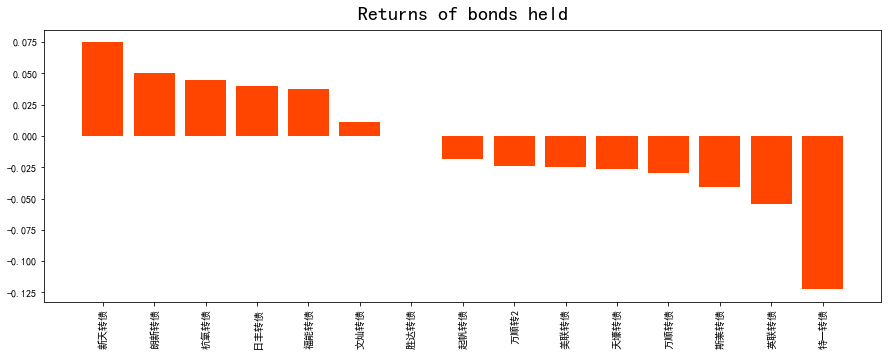

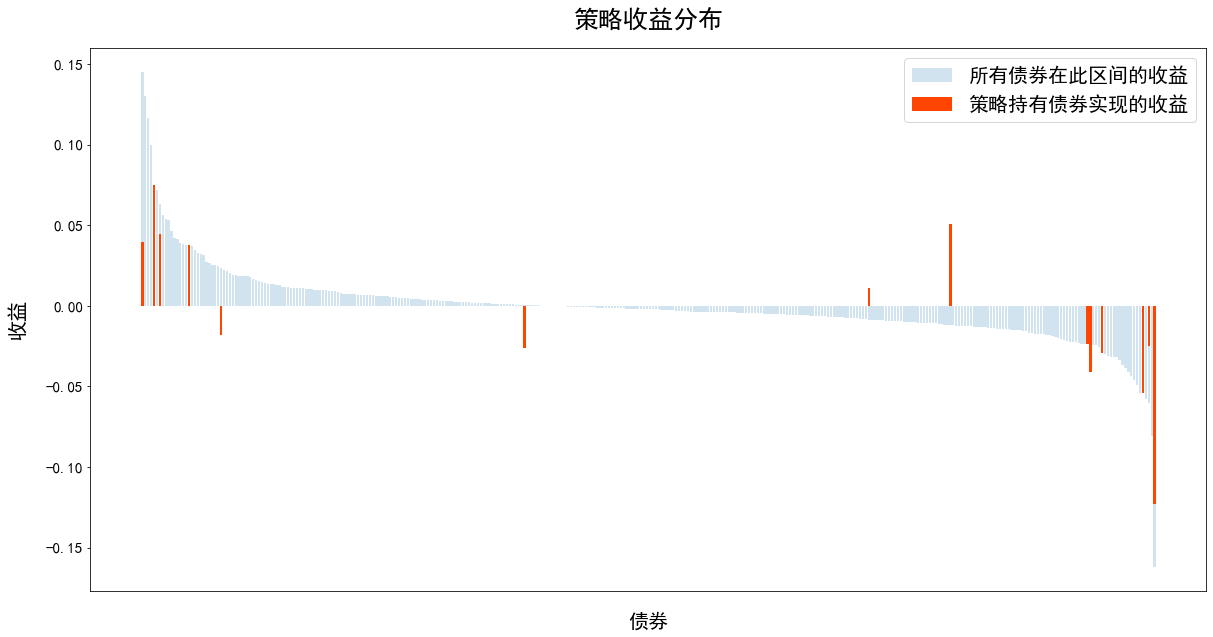

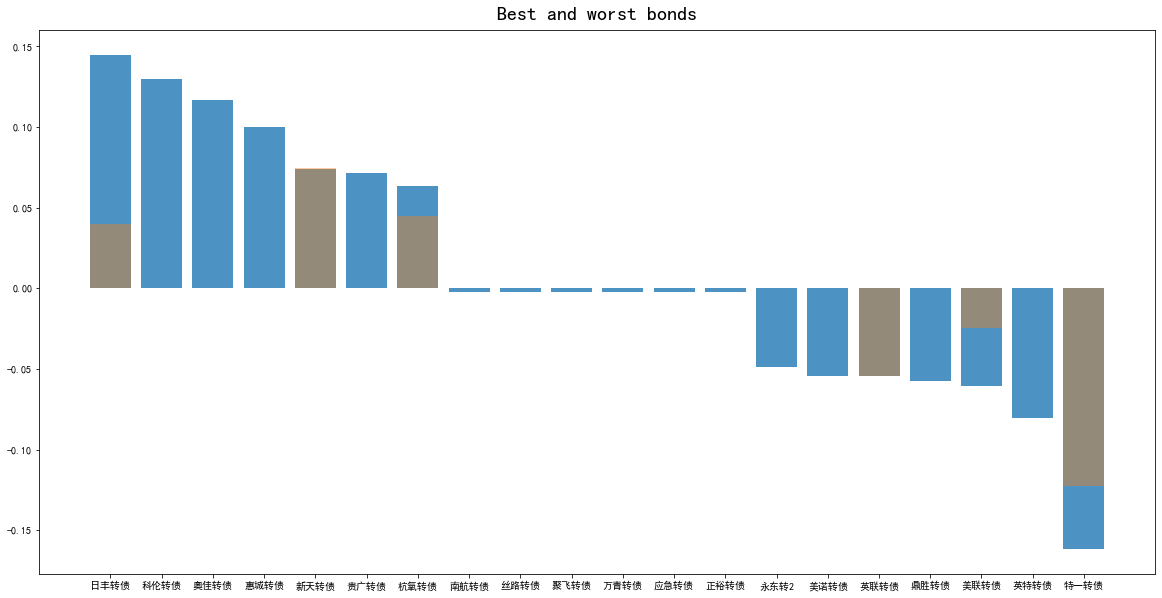

In [304]:
week_hld_cumret,week_all_cumret = Cal_hld_performance(weekly_ret)

# 计算给定区间的三维表现

In [39]:
'''绘制三维图形需要先进行数据转换'''
def mesh(rank_ret,way):
    rank_ret = pd.DataFrame(rank_ret)
    rank_ret_long = rank_ret.unstack().reset_index()
    rank_ret_long.columns = ['Index','Date','Value']
    if way=='full':
        Y = np.array([list(rank_ret.index)]*rank_ret.shape[1]).T
        X = np.array([list(rank_ret.columns)]*rank_ret.shape[0])
        Z = np.array(rank_ret)
        return X,Y,Z
    else:
        return rank_ret_long
    
'''绘制每一天选择的债券在所有债券中的分布'''
def Cal_hld_3D(weekly_ret):
    weekly_ret['day_rank'] = weekly_ret.tday.rank(method='dense')
    rank_hld_ret = []
    rank_ret = []
    for i in weekly_ret.day_rank.unique():
        daily_ret = weekly_ret[weekly_ret.day_rank==i].sort_values('Close_ret',ascending=False)
        rank_hld_ret.append(list(daily_ret.Close_ret*daily_ret.hld))
        rank_ret.append(list(daily_ret.Close_ret))
    
    tX,tY,tZ = mesh(rank_ret,'full')
    XYZ = mesh(rank_hld_ret,'Sparse')
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.scatter(XYZ.Index,XYZ.Date,XYZ.Value,color = 'black')
    ax.plot_wireframe(tX, tY, tZ, rstride=1, cstride=4, color = 'blue',alpha=0.2)
    ax.set_xlabel('Rank',fontsize=15)
    ax.set_ylabel('Date',fontsize=15)
    ax.set_zlabel('Return',fontsize=15)
    plt.title('Returns of all bonds (3D)',fontsize=20,pad=10)

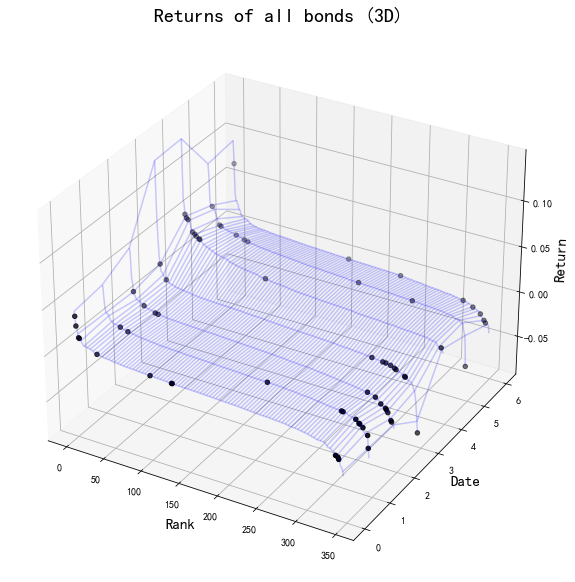

In [14]:
Cal_hld_3D(weekly_ret)

# 策略净值曲线

In [40]:
def Cal_port_line(hld_rev,date_slice=[]):
    hld_rev['tday'] = pd.to_datetime(hld_rev['tday'])
    hld_rev['ret_hld'] = hld_rev['hld'] * hld_rev['Close_ret']
    nr = 'ret_hld'
    rev_profit = hld_rev.groupby('tday')[nr].sum()/hld_rev.groupby('tday')[nr].count()
    #rev_profit.cumsum().plot()
    Port_perf = index.set_index('TRADE_DT')
    Port_perf.rename(columns = {'CLOSE':'Index'},inplace=True)
    Port_perf = Port_perf.pct_change()
    Port_perf['port'] = rev_profit
    
    '''所有时间至今的净值曲线'''
    Port_perf = Port_perf.dropna()
    Port_perf.loc[Port_perf.index.min(),:]=0
    Port_cum_perf = ((1+Port_perf).cumprod()-1)
    Port_cum_perf.plot(figsize=(15,8))
    plt.fill_between(Port_cum_perf.index,Port_cum_perf.port-Port_cum_perf.Index,alpha=0.2)
    plt.title('Portfolio payoff',fontsize=20,pad=15)
    
    '''今年至今的净值曲线'''
    year = datetime.datetime.now().year
    t0,t1 = datetime.datetime(year-1,1,1),datetime.datetime(year,1,1)
    Port_year_perf = Port_perf.loc[t0:t1]
    Port_year_perf = Port_year_perf.dropna()
    Port_year_perf.loc[Port_year_perf.index.min(),:]=0
    Port_cum_year_perf = ((1+Port_year_perf).cumprod()-1)
    Port_cum_year_perf.plot(figsize=(15,8))
    plt.fill_between(Port_cum_year_perf.index,Port_cum_year_perf.port-Port_cum_year_perf.Index,alpha=0.2)
    plt.title(str(year)+' Portfolio payoff',fontsize=20,pad=15)
    
    '''所选择时间区间的净值曲线'''
    if len(date_slice)!=0:
        t0,t1 = datetime.datetime.strptime(date_slice[0],'%Y%m%d'),datetime.datetime.strptime(date_slice[1],'%Y%m%d')
        Port_sel_perf = Port_perf.loc[t0:t1]
        Port_sel_perf = Port_sel_perf.dropna()
        Port_sel_perf.loc[Port_sel_perf.index.min(),:]=0
        Port_cum_sel_perf = ((1+Port_sel_perf).cumprod()-1)
        Port_cum_sel_perf.plot(figsize=(15,8))
        plt.fill_between(Port_cum_sel_perf.index,Port_cum_sel_perf.port-Port_cum_sel_perf.Index,alpha=0.2)
        plt.title('Portfolio payoff selected',fontsize=20,pad=15)
    
    return hld_rev,Port_perf

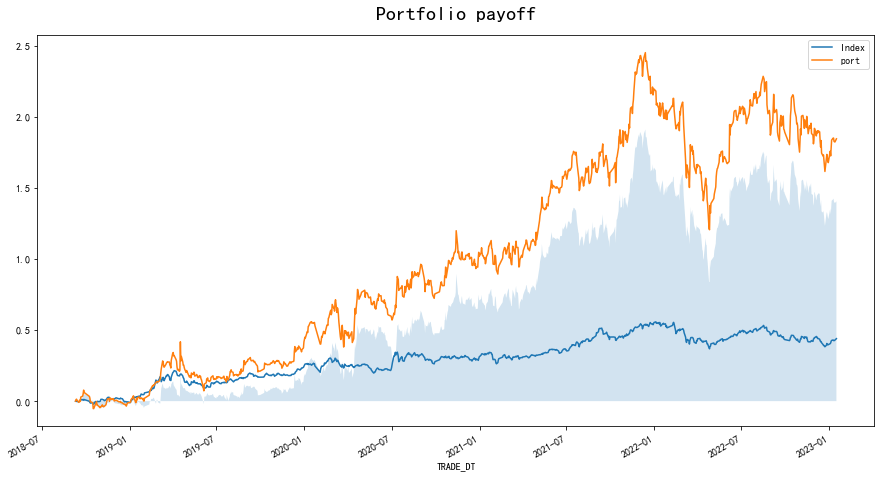

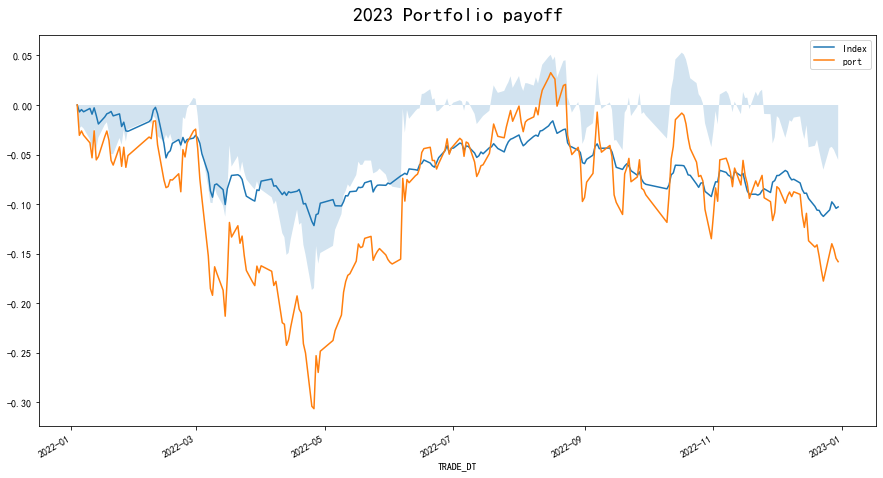

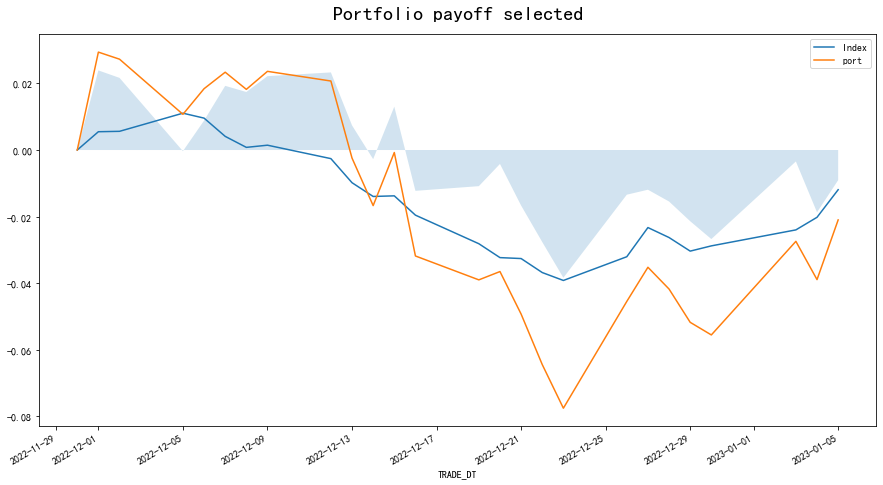

In [16]:
hld_rev,Port_perf = Cal_port_line(hld_rev,['20221130','20230105'])

In [305]:
def Cal_Industry_exposure(weekly_ret):
    def f_cum(x):
        if len(x.dropna())==0:
            return np.nan
        else:
            return ((1+x).cumprod()-1).dropna().iloc[-1]

    '''计算行业指数，扩展数据表，将对应的多个行业拆开'''
    weekly_ret_indus = weekly_ret.drop('行业分类一级',axis=1).join(weekly_ret.行业分类一级.str.\
                                                             split(' ',expand=True).stack().reset_index(level=1,drop=True).rename('行业分类一级'))
    
    '''计算行业收益'''
    all_indus = weekly_ret_indus.groupby(['行业分类一级','tday']).Close_ret.mean().reset_index().\
    sort_values(by='tday').drop('tday',axis=1).groupby('行业分类一级').apply(f_cum).sort_values(by='Close_ret',ascending=False)#.plot(kind='bar')

    '''计算持仓行业收益'''
    hld_indus = weekly_ret_indus[~weekly_ret_indus.hld.isna()].groupby(['行业分类一级','tday']).Close_ret.mean().reset_index().\
    sort_values(by='tday').drop('tday',axis=1).groupby('行业分类一级').apply(f_cum).sort_values(by='Close_ret').rename(columns = {'Close_ret':'Hld_return'})#.plot(kind='bar',color='red')

    '''计算持仓行业数量'''
    hld_count = weekly_ret_indus[~weekly_ret_indus.hld.isna()].groupby(['行业分类一级']).Close_ret.count()\
    .reset_index().sort_values(by='Close_ret').rename(columns = {'Close_ret':'Hld_count'}).set_index('行业分类一级')

    '''持仓数据标准化'''
    hld_count = (hld_count-hld_count.min())/(hld_count.max()-hld_count.min())/10

    '''画图'''
    plt.figure(figsize=(15,7))
    plt.bar(all_indus.index,all_indus.Close_ret,alpha=0.5)
    plt.bar(hld_indus.index,hld_indus.Hld_return,alpha=0.5,color='orangered')
    #plt.scatter(hld_count.index,hld_count.Hld_count,alpha=1)
    plt.xticks(all_indus.index,rotation=60,fontsize=15)
    plt.legend(['行业转债平均收益','策略各行业平均收益'],fontsize=20)
    plt.title('策略行业归因分析',fontsize=25,pad=20)
    #ax2.set_xticks(all_indus.index)
    plt.yticks(fontsize=15)
    plt.xlabel('行业',fontsize=20,labelpad=0)
    plt.ylabel('收益',fontsize=20,labelpad=10)
    plt.show()
    
    return pd.concat([all_indus,hld_indus,hld_count],axis=1)

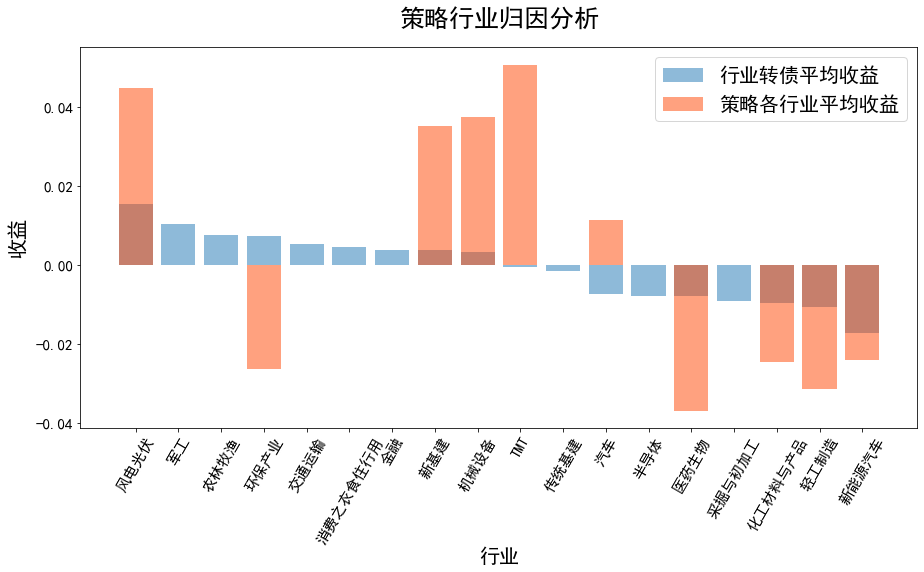

In [307]:
indus_result = Cal_Industry_exposure(weekly_ret)

In [486]:
def VaR(weekly_ret):
    hld_loss  = -weekly_ret.dropna(subset={'hld'}).Close_ret
    nbins=int(len(hld_loss)/5)
    plt.figure(figsize=(10,7))
    a = plt.hist(list(hld_loss),bins=nbins,color='skyblue')
    VaR95 = hld_loss.quantile(0.95)
    VaR99 = hld_loss.quantile(0.99)
    #(hld_loss[hld_loss>=VaR]).hist()
    plt.vlines(x = VaR95,ymin=0,ymax=a[0].max()/2, color = 'green')
    plt.vlines(x = VaR99,ymin=0,ymax=a[0].max()/2, color = 'red')
    plt.legend(['95% VaR:'+str(round(VaR95,3)),'99% VaR:'+str(round(VaR99,3))],fontsize=20)
    plt.xlabel('日度亏损',fontsize=20)
    plt.ylabel('频数',fontsize=20)
    plt.title('策略VaR',fontsize=25,pad=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    

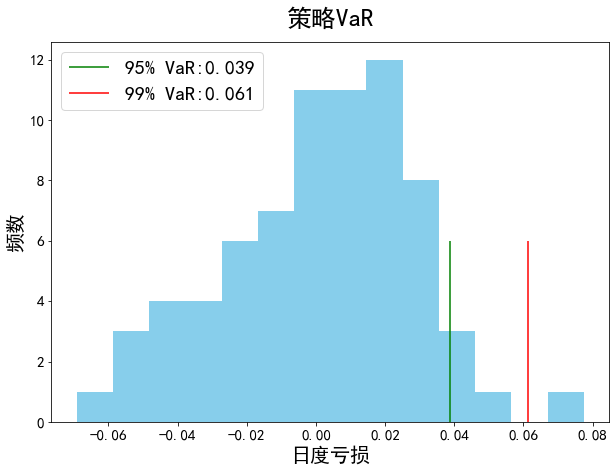

In [487]:
VaR(weekly_ret)

# 综合函数

In [488]:
def Cal_all(hld_rev,fac_name,show_name,date_slice=['20221201','20221231']):
    t0,t1 = datetime.datetime.strptime(date_slice[0],'%Y%m%d'),datetime.datetime.strptime(date_slice[1],'%Y%m%d')
    
    '''绘制净值曲线'''
    hld_rev,Port_perf = Cal_port_line(hld_rev,date_slice)
    
    '''计算策略的各种评价指标'''
    print('Returns:')
    print('\nPortfolio:')
    Res_df = pd.concat([Return_cal(Port_perf.port,show_name).round(4),Return_cal(Port_perf.Index,'指数').round(4)],axis=1)
    Res_df = Res_df.applymap(lambda x: format(x,'.1%'))
    print(Res_df)
    
    '''在选择的时间区间内'''
    weekly_ret = hld_rev[(hld_rev.tday >= t0) &
                         (hld_rev.tday < t1)  & 
                          (~hld_rev[fac_name].isna())].sort_values('tday',ascending=True)

    '''计算选择债券在所有债券中的表现及分布'''
    week_hld_counts,week_hld_return = Cal_hld_information(weekly_ret)
    week_hld_cumret,week_all_cumret = Cal_hld_performance(weekly_ret)
    Cal_hld_3D(weekly_ret)
    
    '''计算行业暴露'''
    indus_result = Cal_Industry_exposure(weekly_ret)
    
    '''计算VaR风险管理'''
    VaR(weekly_ret)

    return week_hld_counts,week_hld_return,hld_rev,indus_result

# 展示

In [489]:
hld_rev = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/中短期趋势背离择券1号_纯反转.csv')
hld_pbroe = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/长短期动量反转锐利3号_纯PBROE.csv')
hld_pbroe1 = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/长短期动量反转择券2号_大盘择时pbroe.csv')
hld_pbroe2 = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/8双低2pbroe_稳健策略.csv')
hld_ind_rev = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/测试-中短期趋势背离择券_行业轮动.csv')
hld_rev_cl = pd.read_csv('/home/aifi/script/jupyter_projects/hjc/cb/每天推荐/Report/Data/中短期趋势背离择券1号_纯反转止损.csv')
hld_rev_cl['hld'] = (hld_rev_cl['hld']&(hld_rev_cl ['CDLHANGINGMAN_sig'].isna())).replace(False,np.nan)

Returns:

Portfolio:
                    纯反转      指数
Ret (D)            0.7%    0.7%
Ret (W)           -0.2%    0.7%
Ret (M)            2.0%    1.5%
Ret (Q)           -7.4%   -0.8%
Ret (Y)          -12.1%   -6.7%
Ret (MTD)          6.2%    3.0%
Ret (YTD)          6.2%    3.0%
Ret (Y)           -7.2%   -6.3%
Vol (Y)           33.2%   10.0%
Sharpe (Y)       -21.8%  -63.0%
MaxDrawDown (Y)   31.0%   12.2%
VaR95% (Y)        -3.2%   -0.9%
VaR99% (Y)        -2.3%   -0.7%


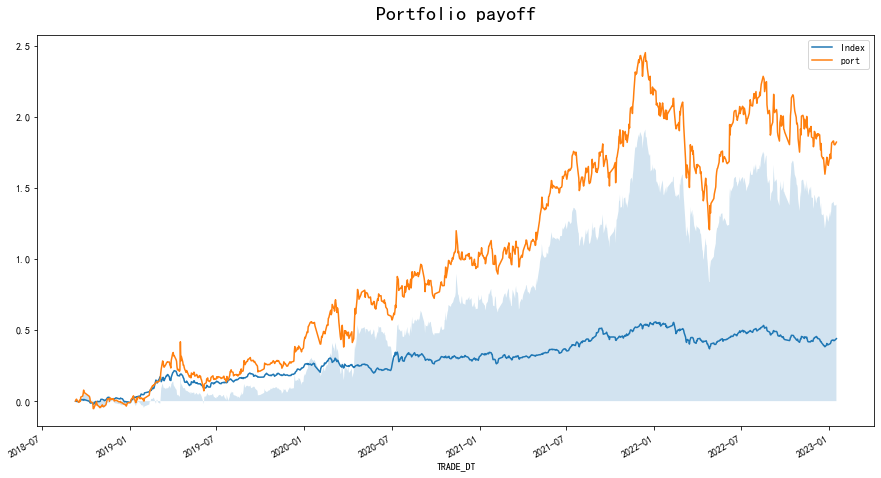

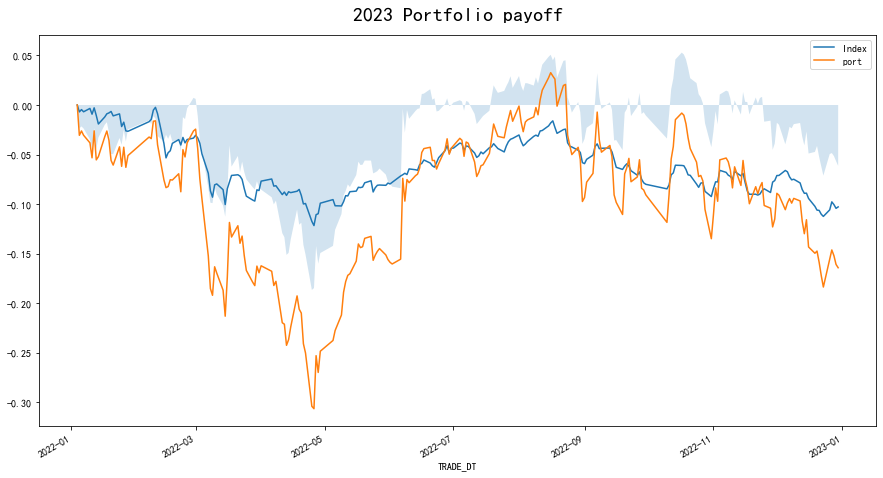

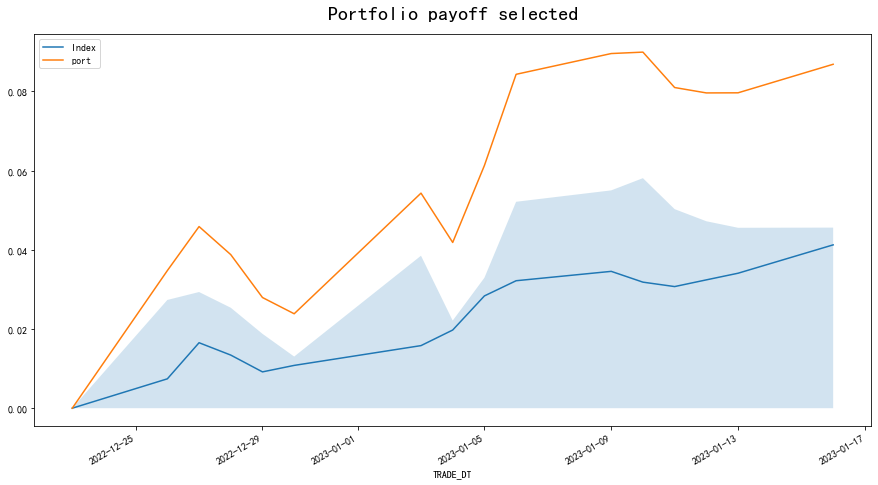

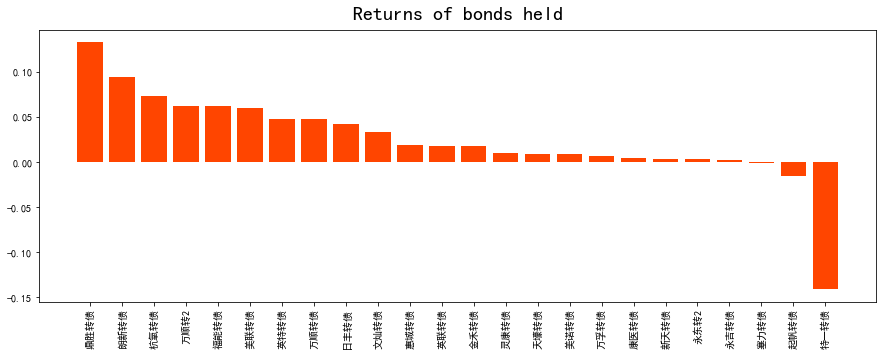

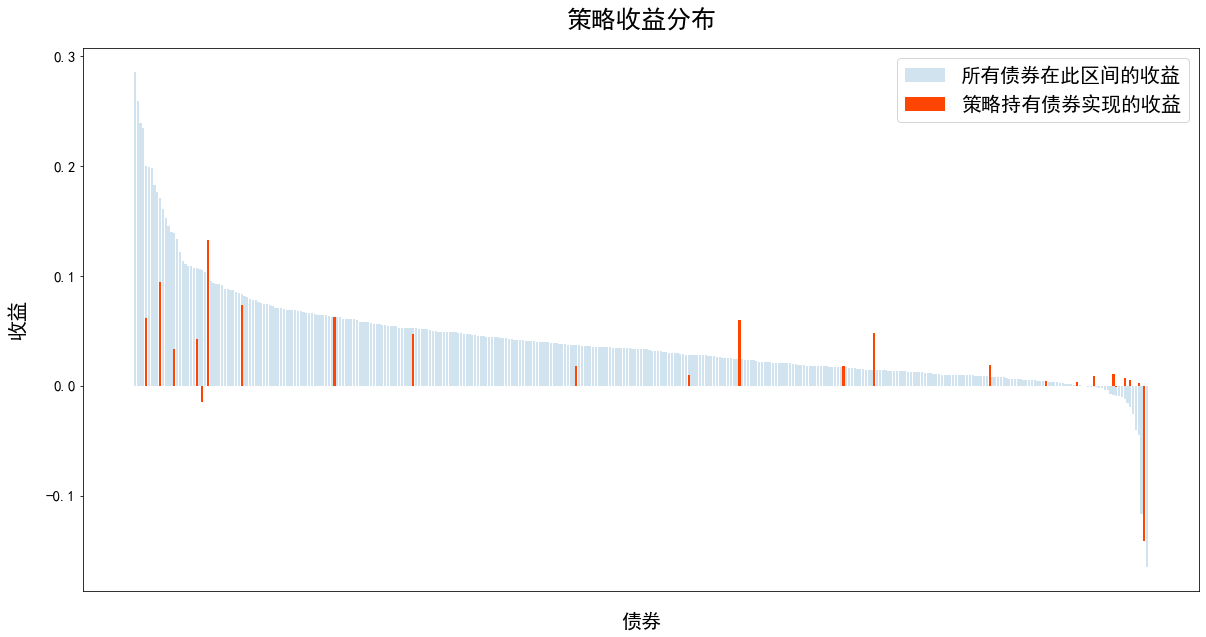

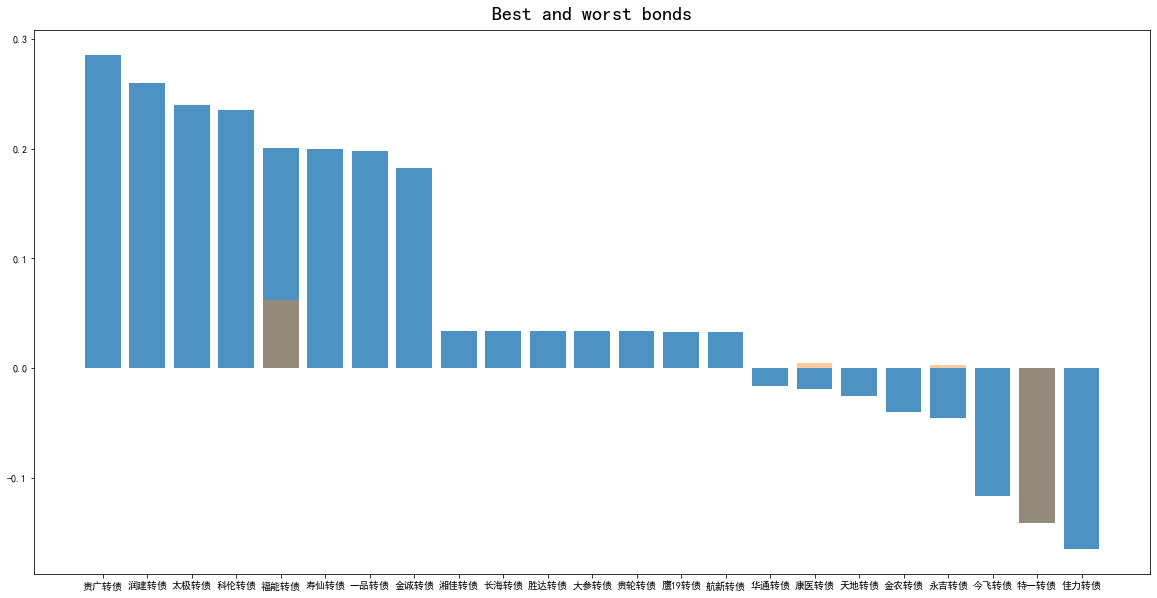

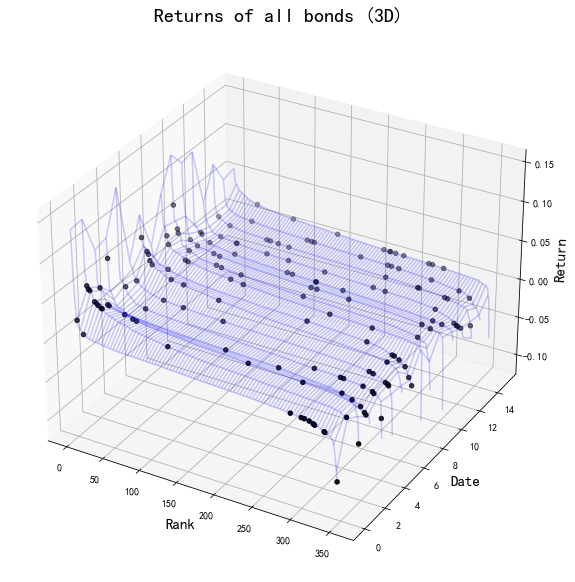

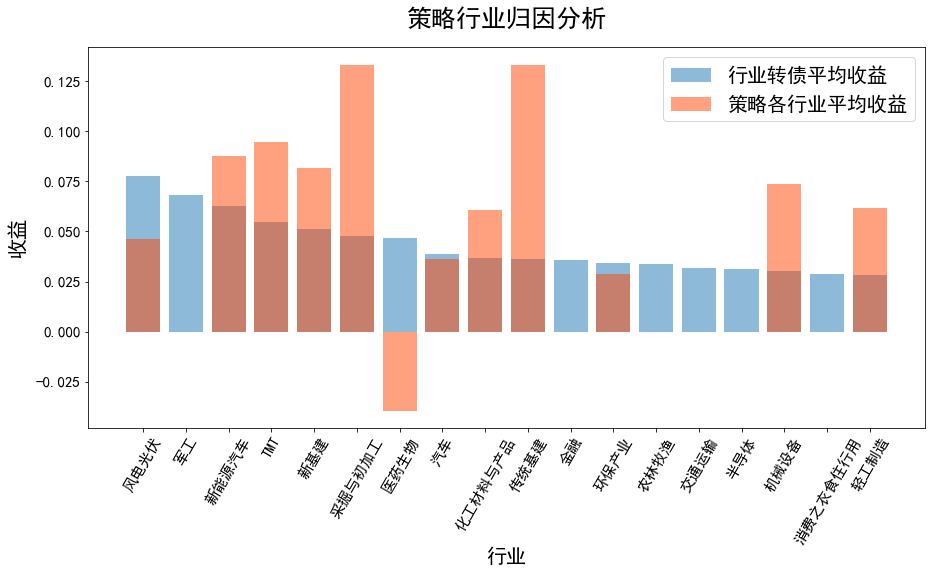

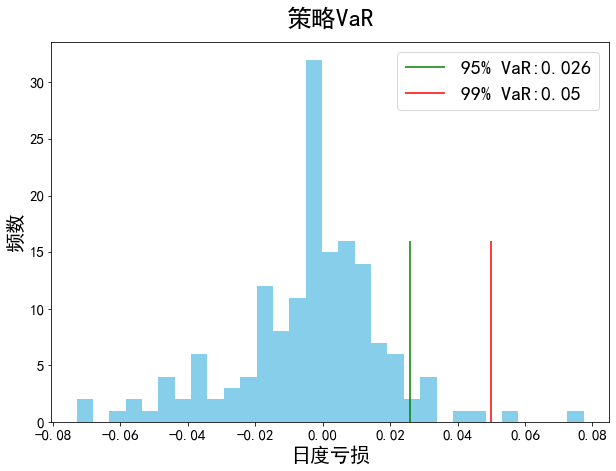

In [490]:
week_hld_counts,week_hld_return,hld_rev1,hld_indus = Cal_all(hld_rev,'factor','纯反转',['20221223',today_str])

Returns:

Portfolio:
                   纯反转      指数
Ret (D)           0.8%    0.7%
Ret (W)           1.0%    0.7%
Ret (M)           1.5%    1.5%
Ret (Q)           3.5%   -0.8%
Ret (Y)          17.0%   -6.7%
Ret (MTD)         3.3%    3.0%
Ret (YTD)         3.3%    3.0%
Ret (Y)          18.1%   -6.3%
Vol (Y)          22.6%   10.0%
Sharpe (Y)       79.9%  -63.0%
MaxDrawDown (Y)  13.7%   12.2%
VaR95% (Y)       -2.6%   -0.9%
VaR99% (Y)       -1.8%   -0.7%


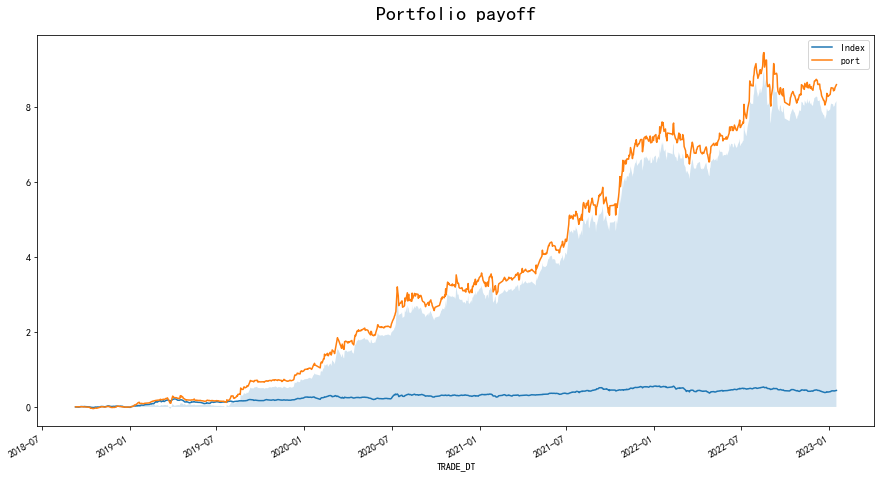

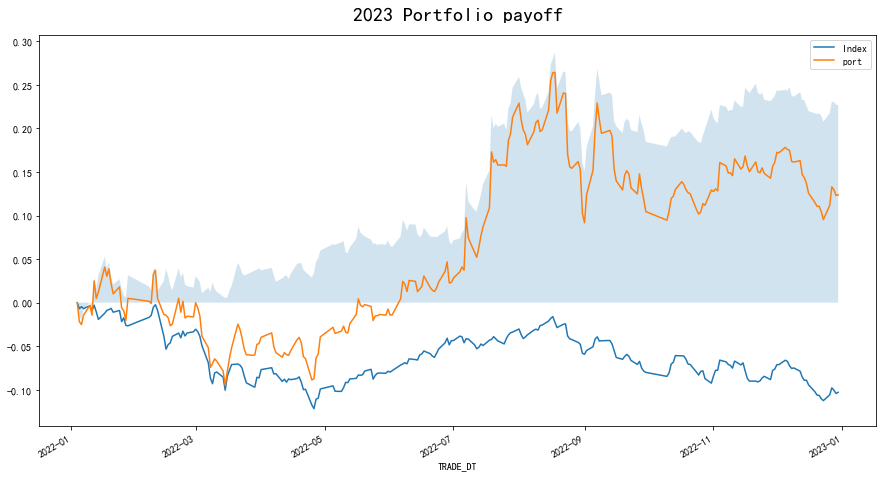

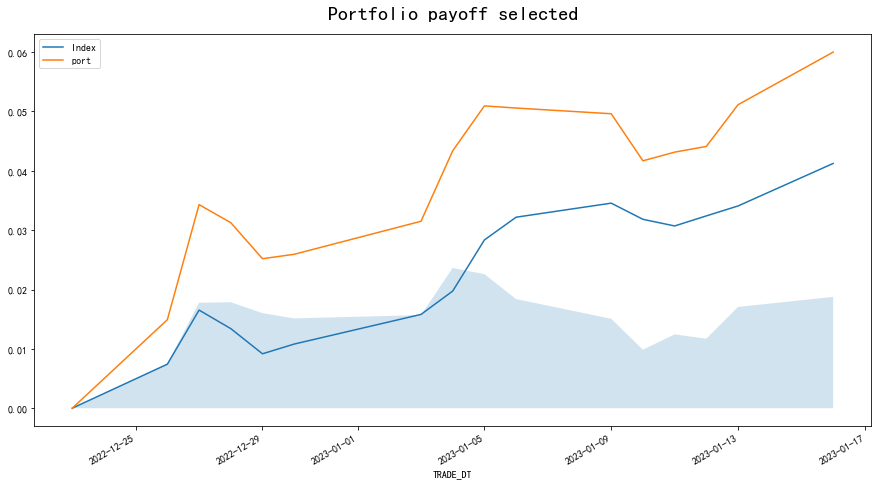

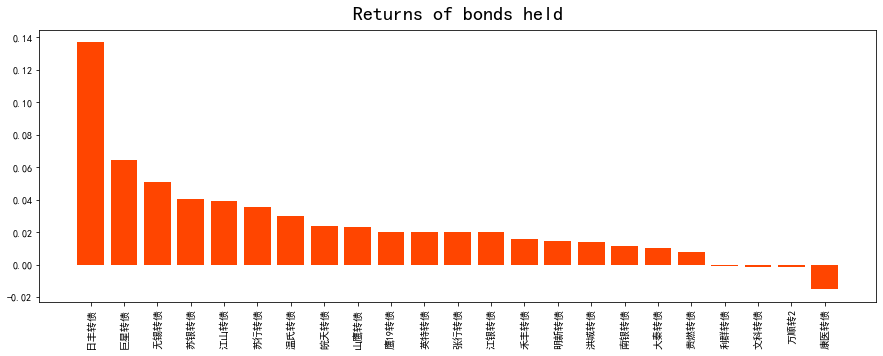

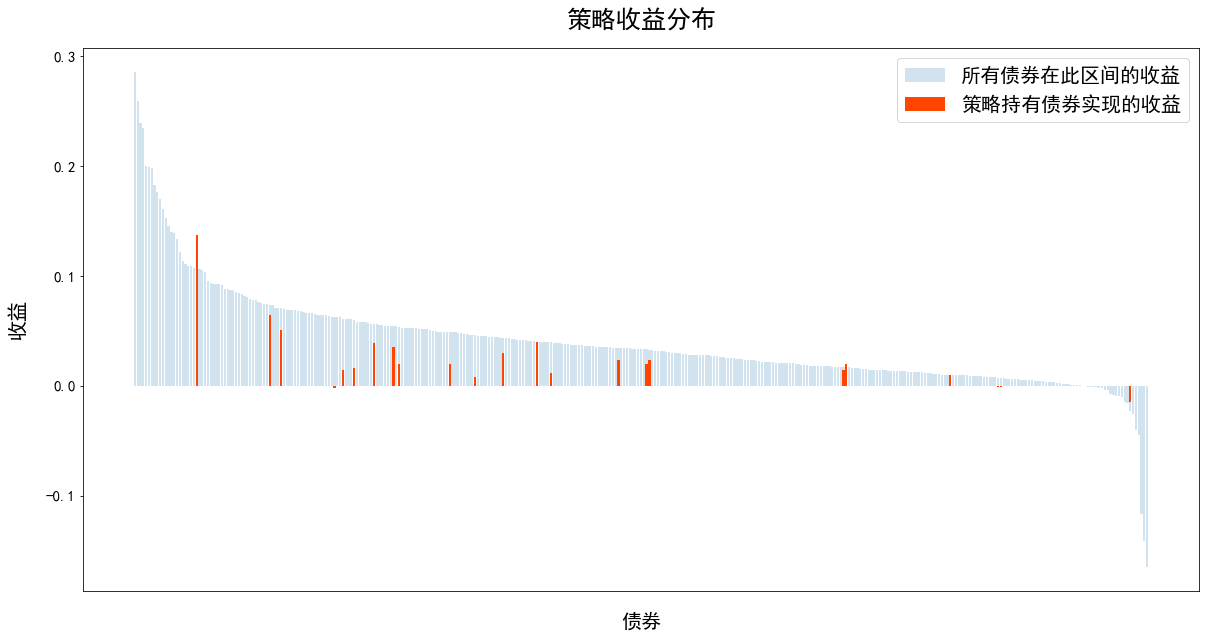

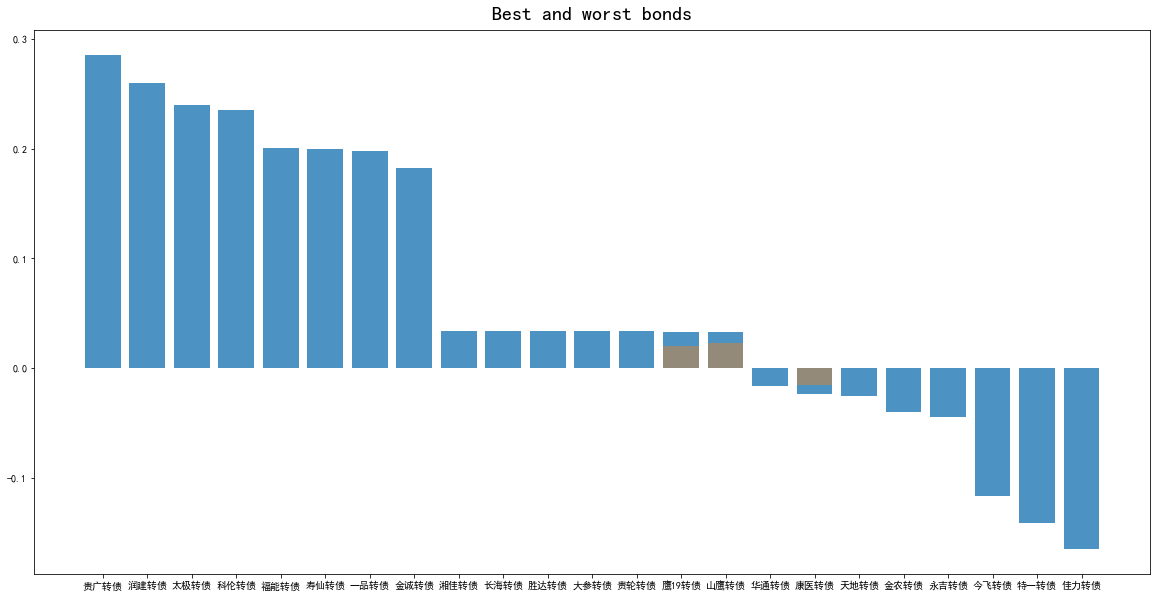

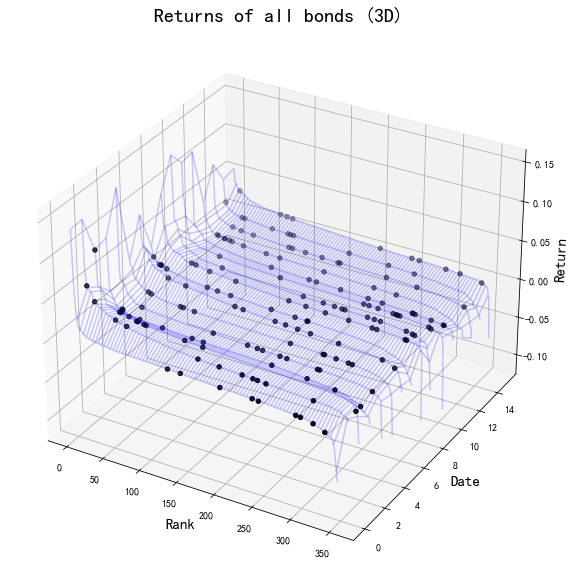

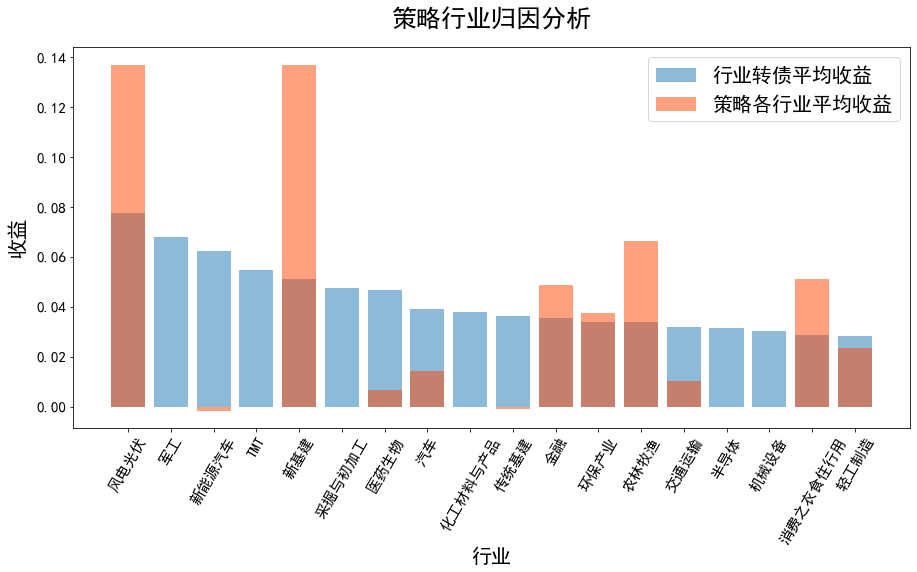

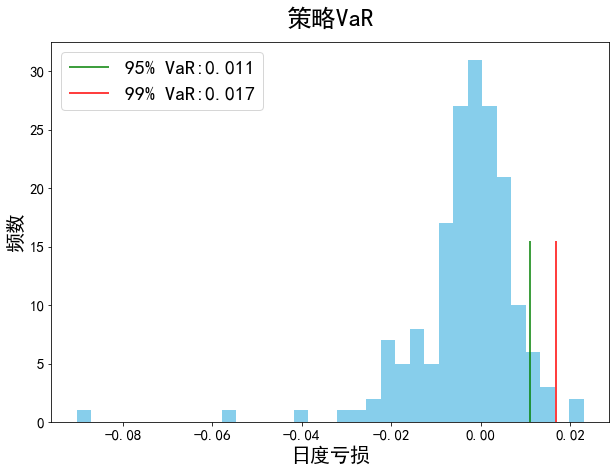

In [491]:
week_hld_counts,week_hld_return,hld_rev1,hld_indus = Cal_all(hld_pbroe1,'factor','纯反转',['20221223',today_str])

Returns:

Portfolio:
                   纯反转      指数
Ret (D)           1.2%    0.7%
Ret (W)           0.2%    0.7%
Ret (M)          -3.8%    1.5%
Ret (Q)          -1.6%   -0.8%
Ret (Y)          -3.7%   -6.7%
Ret (MTD)         4.6%    3.0%
Ret (YTD)         4.6%    3.0%
Ret (Y)          -0.2%   -6.3%
Vol (Y)          26.4%   10.0%
Sharpe (Y)       -0.9%  -63.0%
MaxDrawDown (Y)  28.3%   12.2%
VaR95% (Y)       -2.8%   -0.9%
VaR99% (Y)       -1.8%   -0.7%


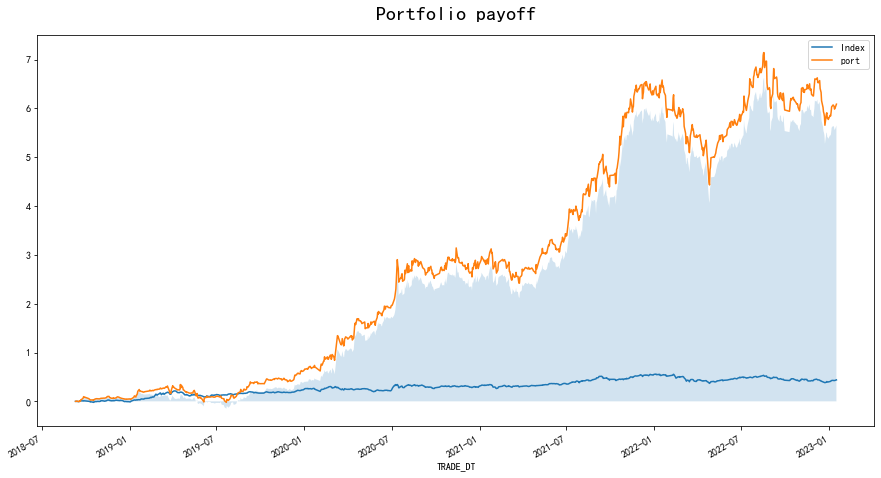

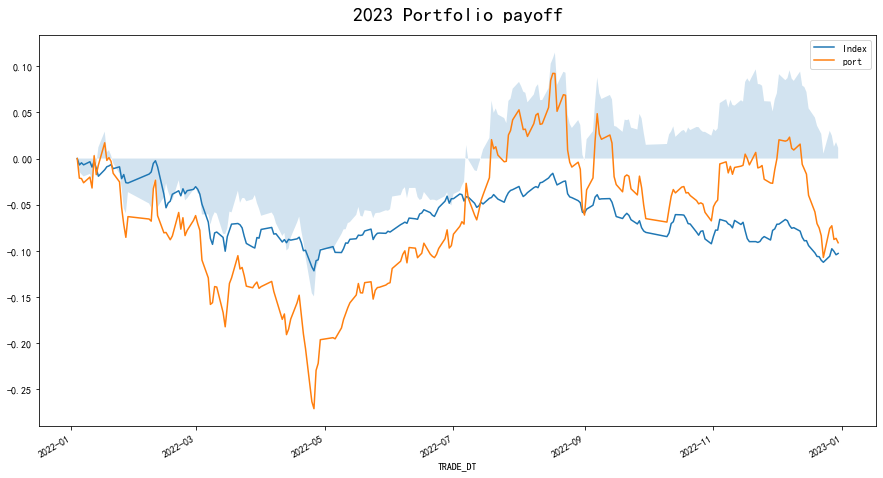

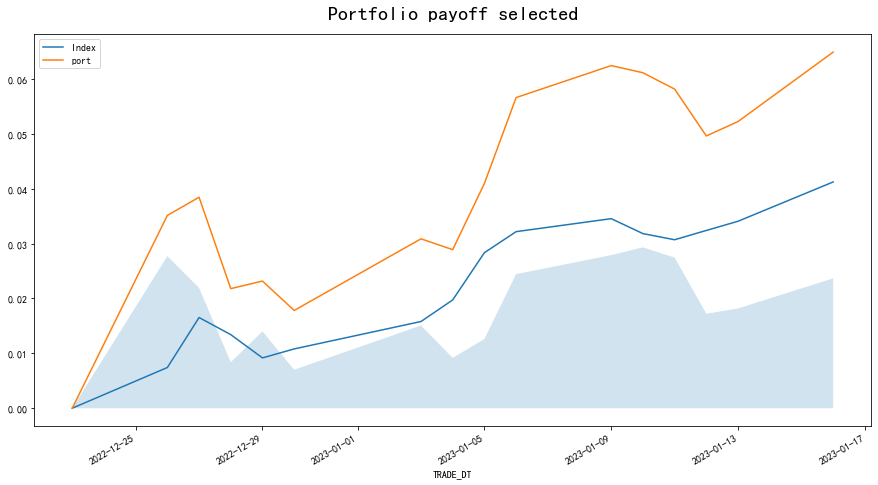

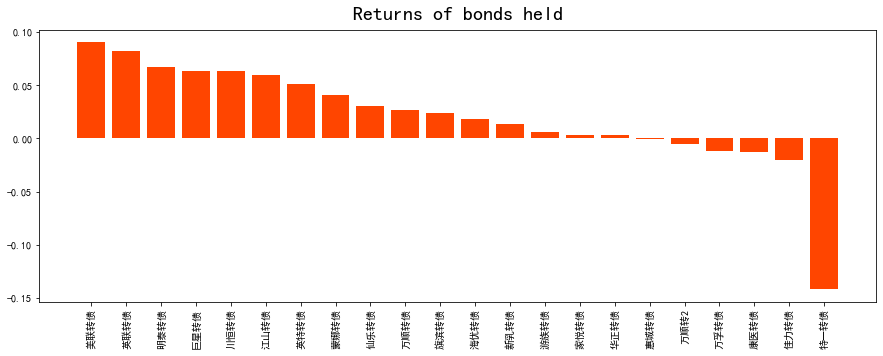

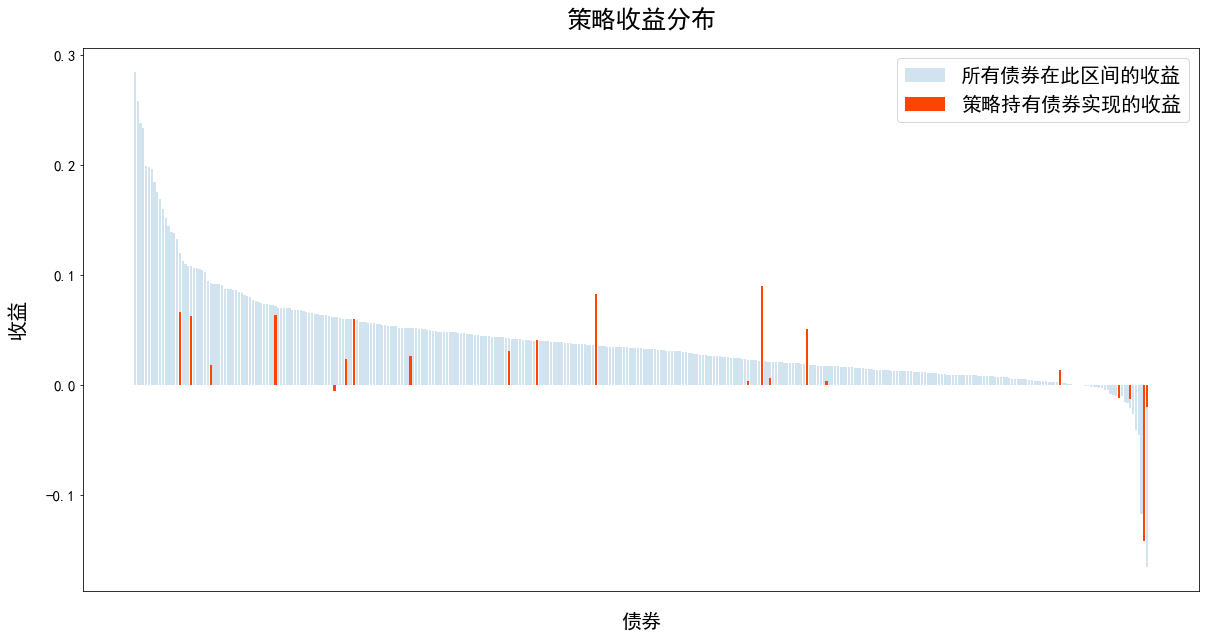

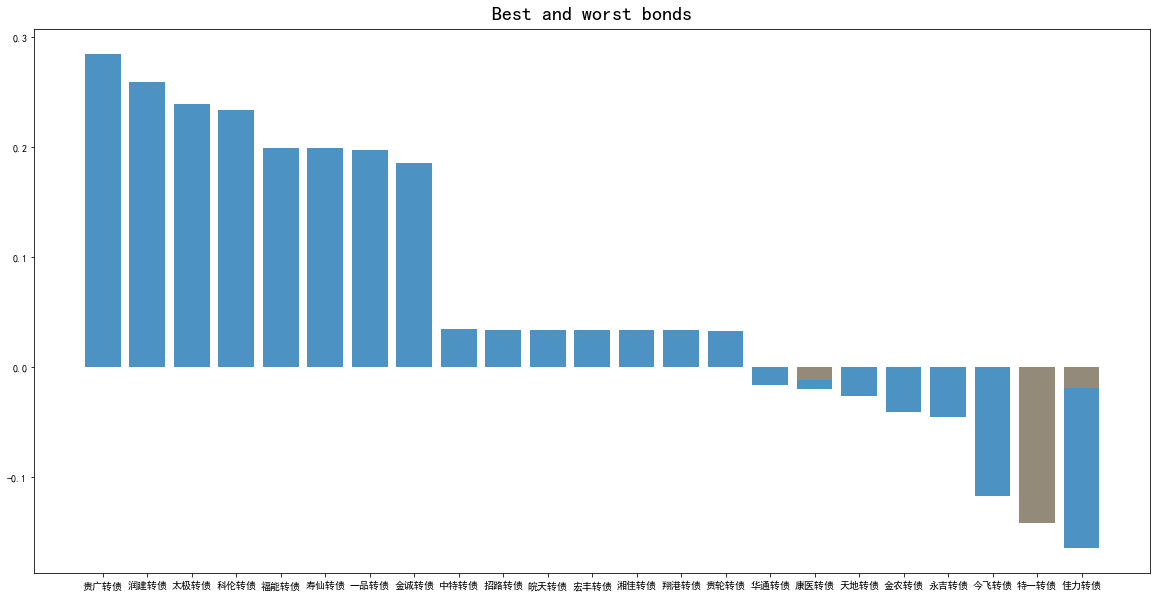

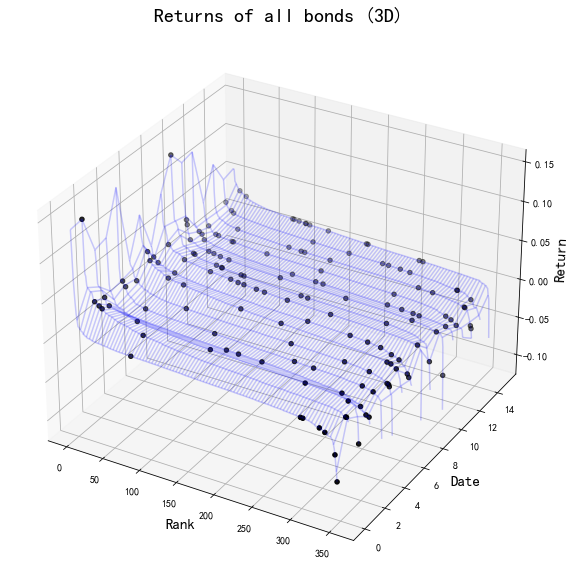

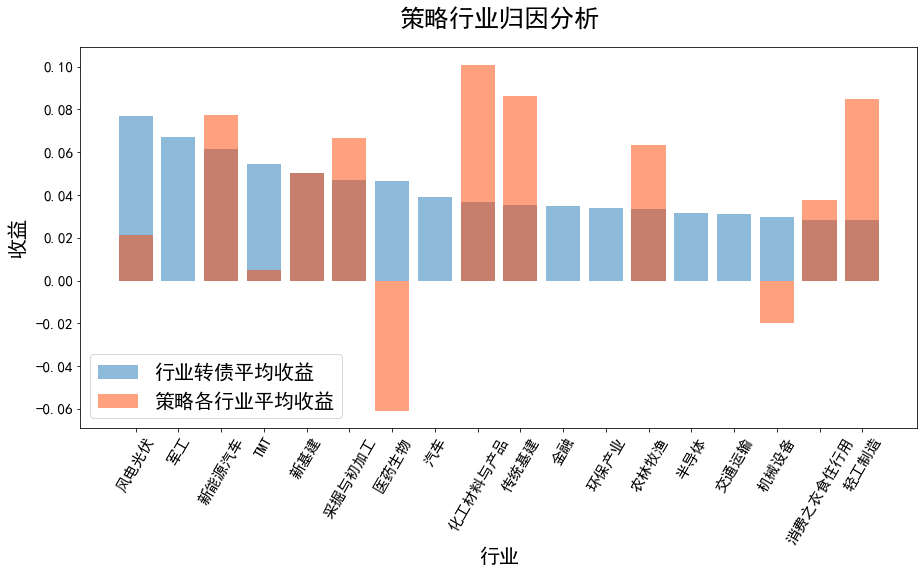

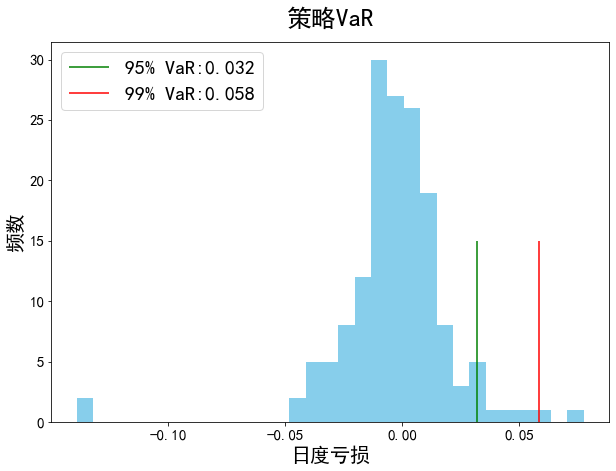

In [492]:
week_hld_counts,week_hld_return,hld_rev1,hld_indus = Cal_all(hld_pbroe,'factor','纯反转',['20221223',today_str])

Returns:

Portfolio:
                   纯反转      指数
Ret (D)           1.1%    0.7%
Ret (W)           0.2%    0.7%
Ret (M)           2.8%    1.5%
Ret (Q)           5.4%   -0.8%
Ret (Y)          16.3%   -6.7%
Ret (MTD)         5.5%    3.0%
Ret (YTD)         5.5%    3.0%
Ret (Y)          17.7%   -6.3%
Vol (Y)          23.8%   10.0%
Sharpe (Y)       74.5%  -63.0%
MaxDrawDown (Y)  19.7%   12.2%
VaR95% (Y)       -2.4%   -0.9%
VaR99% (Y)       -1.8%   -0.7%


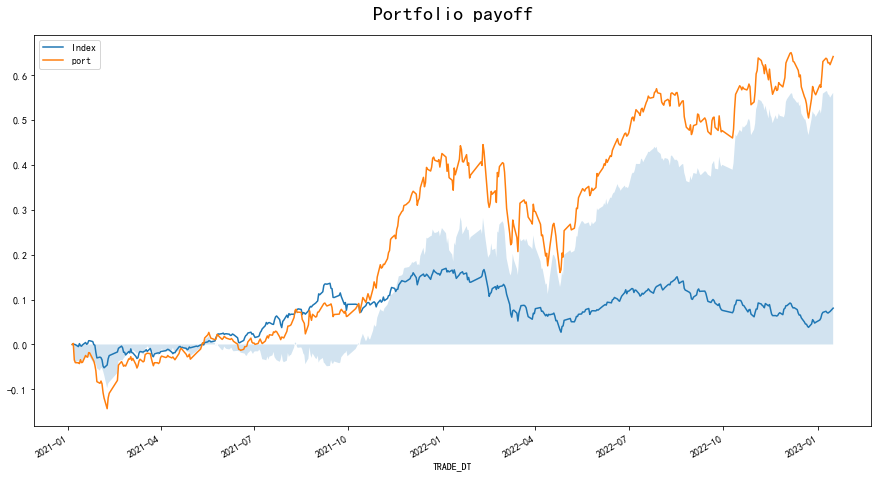

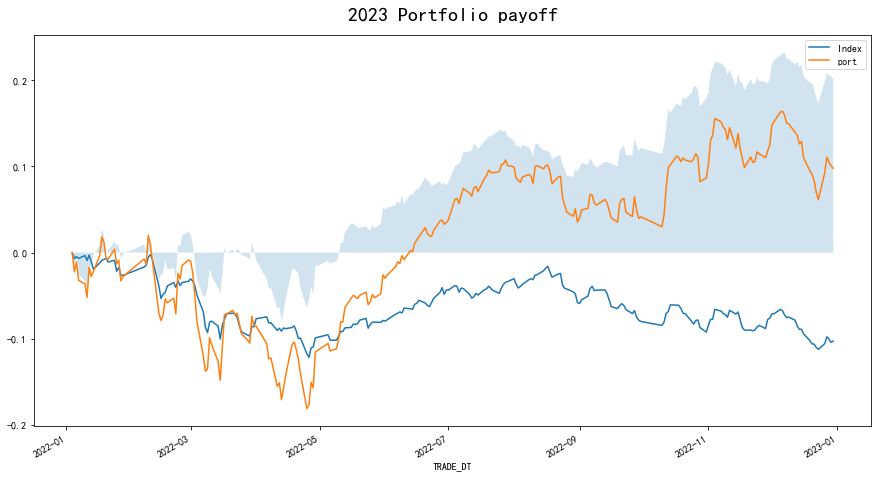

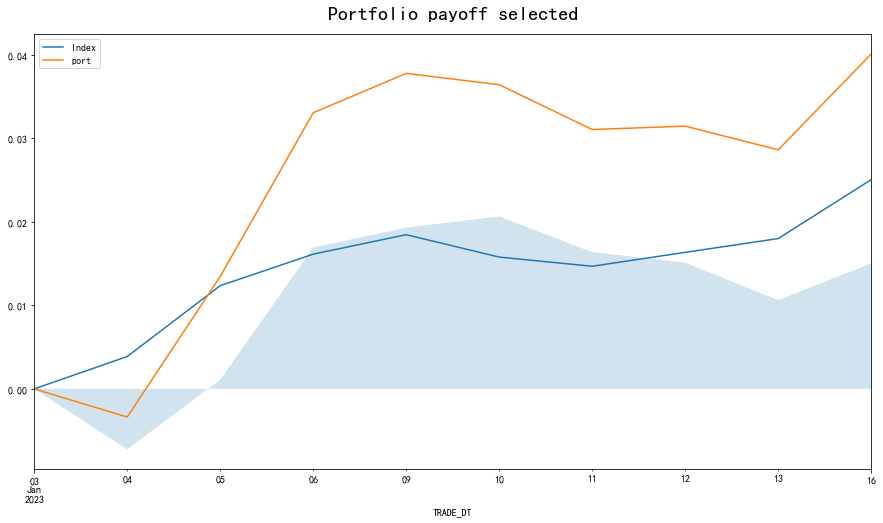

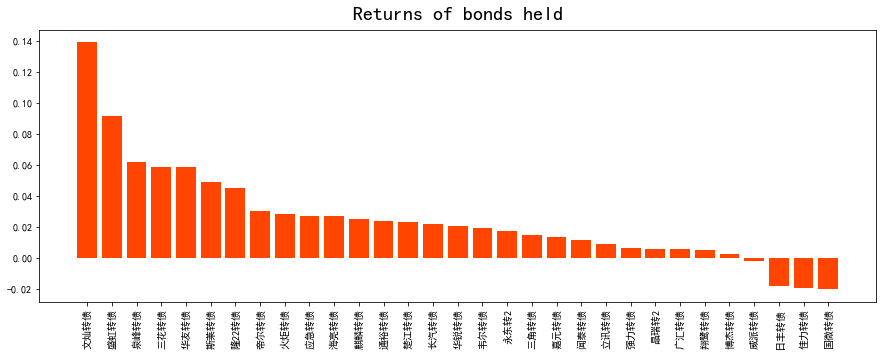

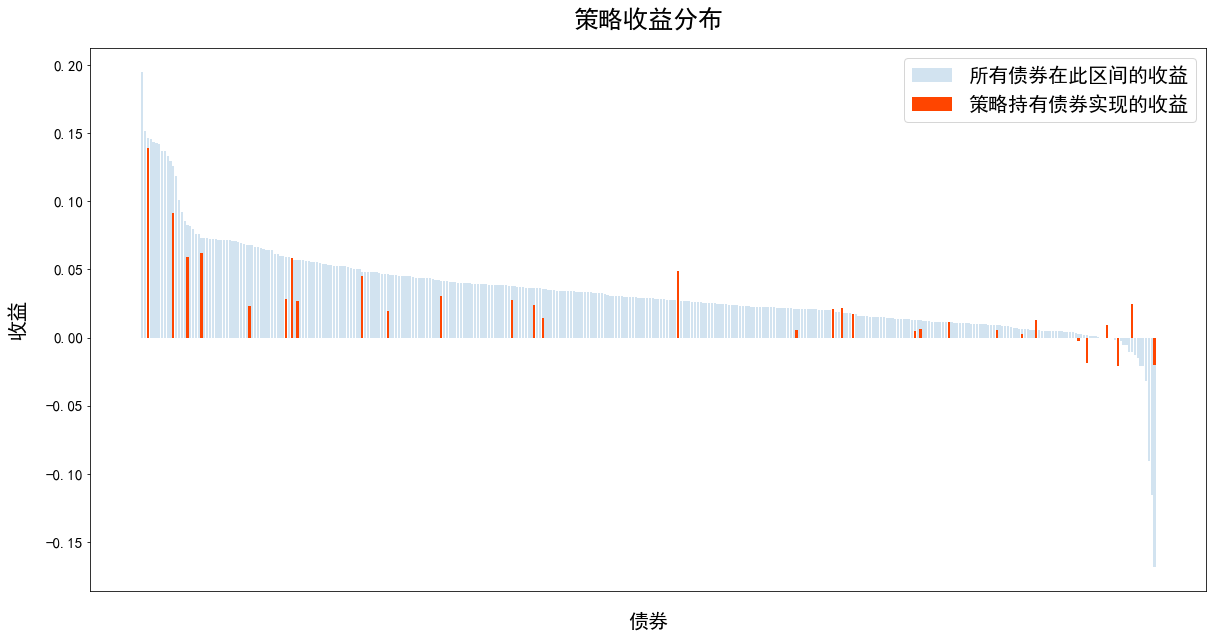

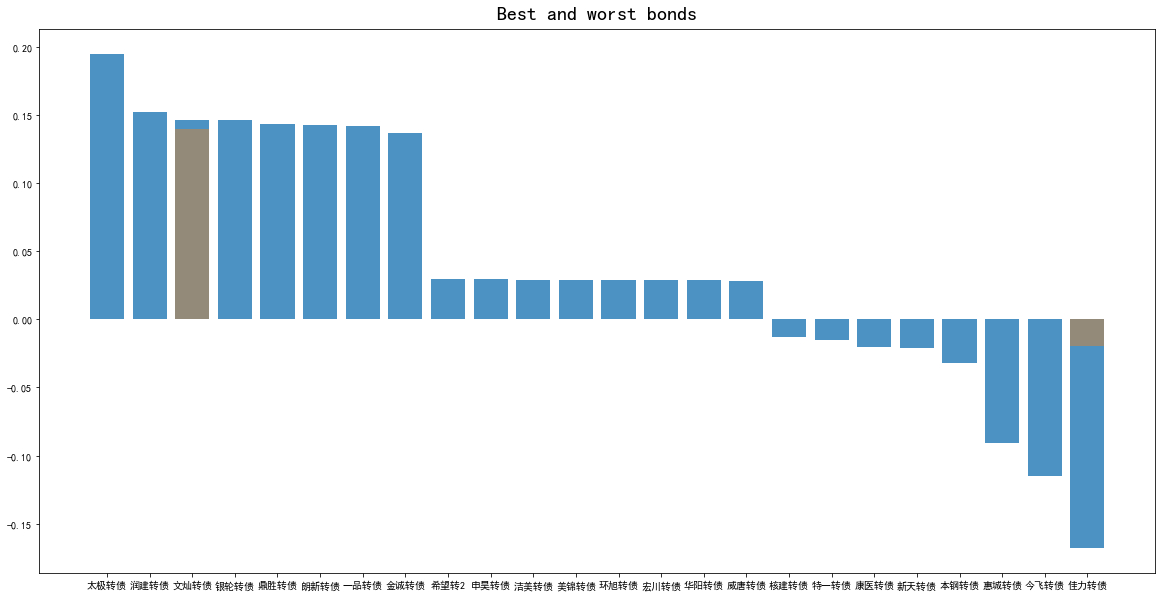

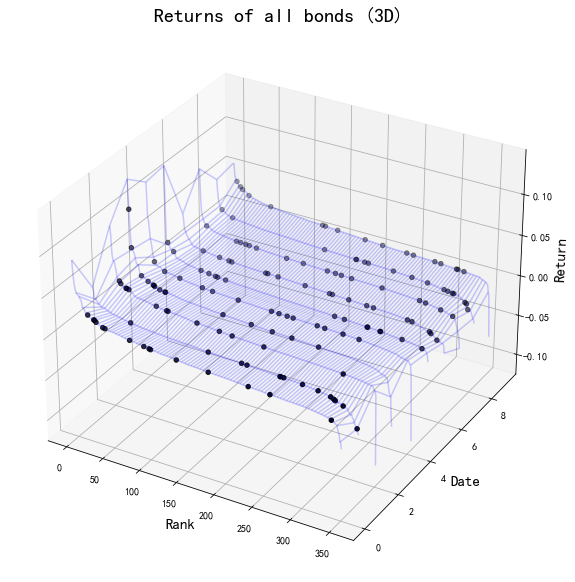

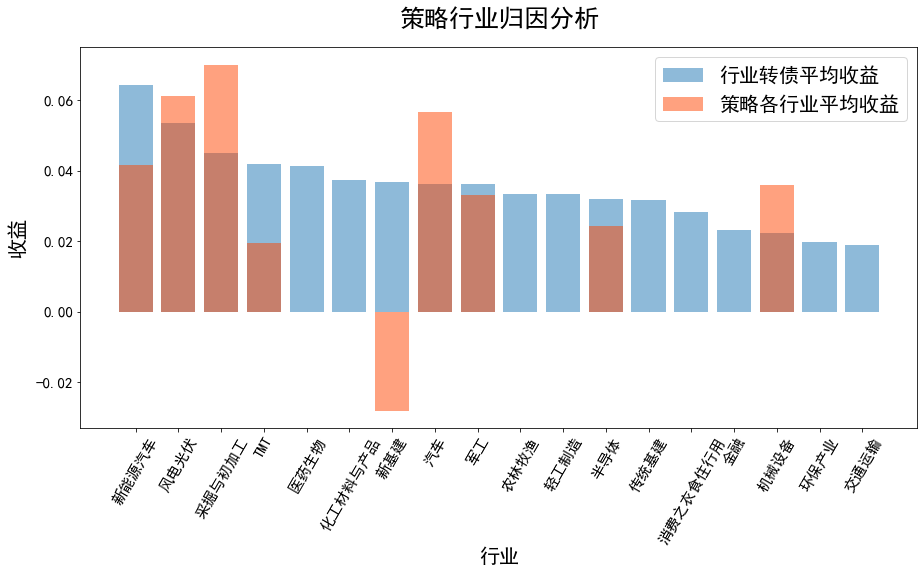

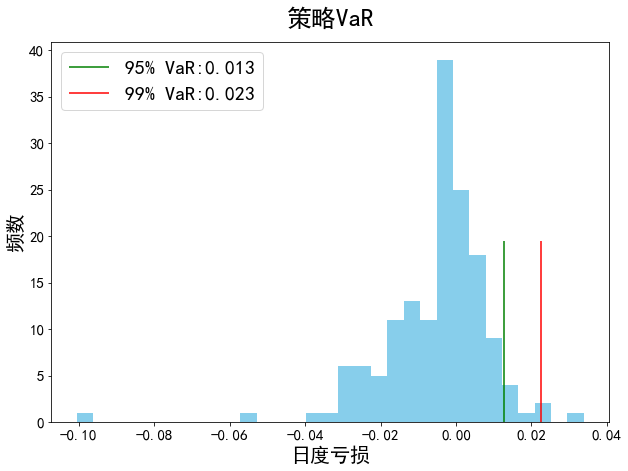

In [493]:
week_hld_counts,week_hld_return,hld_rev1,hld_indus = Cal_all(hld_ind_rev,'factor','纯反转',['20230101',today_str])

# 不同策略比较

In [497]:
'''比较不同策略'''
def Cal_comparison(strat_list=[hld_rev,hld_pbroe],strat_name_list = ['反转','动量反转'],date_range=['20220130','20230105']):
    Port_perf = index.set_index('TRADE_DT')
    Port_perf.rename(columns = {'CLOSE':'Index'},inplace=True)
    Port_perf = Port_perf.pct_change()

    '''循环计算各种策略的评价指标'''
    Res_list = [Return_cal(Port_perf.Index,'指数').round(4)]
    for i in range(0,len(strat_list)):
        hld = strat_list[i]
        hld['tday'] = pd.to_datetime(hld['tday'])
        hld['ret_hld'] = hld['hld'] * hld['Close_ret']
        nr = 'ret_hld'
        rev_profit = hld.groupby('tday')[nr].sum()/hld.groupby('tday')[nr].count()
        Port_perf[strat_name_list[i]] = rev_profit
        Res_list.append(Return_cal(Port_perf[strat_name_list[i]],strat_name_list[i]).round(4))
    Res_df = pd.concat(Res_list,axis=1)
    Res_df = Res_df.applymap(lambda x: format(x,'.1%'))
    Res_df = Res_df.rename(columns = {'指数':'中证转债指数'})
    print(Res_df)
    
    '''绘制所有时间的净值曲线'''
    Port_perf = Port_perf.dropna()
    Port_perf.loc[Port_perf.index.min(),:]=0
    Port_cum_perf = ((1+Port_perf).cumprod()-1)
    Port_cum_perf.drop(columns=['Index']).plot(figsize=(15,10))
    Port_cum_perf.Index.plot(color='red',linewidth=2.5,linestyle='--')
    plt.legend(list(Port_cum_perf.columns)[1:]+['中证转债指数'],loc='upper left',fontsize=15)
    plt.title('2018至今策略收益',fontsize=25,pad=20)
    plt.xlabel('日期',fontsize=20,labelpad=10)
    plt.ylabel('收益',fontsize=20,labelpad=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    '''绘制今年的净值曲线'''
    year = datetime.datetime.now().year
    t0,t1 = datetime.datetime(year-1,1,1),datetime.datetime(year,1,1)
    Port_year_perf = Port_perf.loc[t0:t1].dropna()
    Port_year_perf.loc[Port_year_perf.index.min(),:]=0
    Port_cum_year_perf = ((1+Port_year_perf).cumprod()-1)
    Port_cum_year_perf.drop(columns=['Index']).plot(figsize=(15,10))
    Port_cum_year_perf.Index.plot(color='red',linewidth=2.5,linestyle='--')
    plt.legend(list(Port_cum_year_perf.columns)[1:]+['中证转债指数'],loc='upper left',fontsize=15)
    plt.title(str(year-1)+'至今策略收益',fontsize=25,pad=20)
    plt.xlabel('日期',fontsize=20,labelpad=10)
    plt.ylabel('收益',fontsize=20,labelpad=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    '''绘制所选择时间区间的净值曲线'''
    t0,t1 = datetime.datetime.strptime(date_range[0],'%Y%m%d'),datetime.datetime.strptime(date_range[1],'%Y%m%d')
    Port_sel_perf = Port_perf.loc[t0:t1].dropna()
    Port_sel_perf.loc[Port_sel_perf.index.min(),:]=0
    Port_cum_sel_perf = ((1+Port_sel_perf).cumprod()-1)
    Port_cum_sel_perf.drop(columns=['Index']).plot(figsize=(15,10))
    Port_cum_sel_perf.Index.plot(color='red',linewidth=2.5,linestyle='--')
    plt.legend(list(Port_cum_sel_perf.columns)[1:]+['中证转债指数'],loc='upper left',fontsize=15)
    plt.title('2022-12-23至今的策略收益',fontsize=25,pad=20)
    plt.xlabel('日期',fontsize=20,labelpad=10)
    plt.ylabel('收益',fontsize=20,labelpad=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    return Res_df

In [498]:
#YTD MTD 策略名字 只保留Recent Sharpe 最大回撤 删除evaluations

                 中证转债指数 中短期趋势背离择券1号 长短期动量反转择券2号 长短期动量反转择券3号
Ret (D)            0.7%        0.7%        0.8%        1.2%
Ret (W)            0.7%       -0.2%        1.0%        0.2%
Ret (M)            1.5%        2.0%        1.5%       -3.8%
Ret (Q)           -0.8%       -7.4%        3.5%       -1.6%
Ret (Y)           -6.7%      -12.1%       17.0%       -3.7%
Ret (MTD)          3.0%        6.2%        3.3%        4.6%
Ret (YTD)          3.0%        6.2%        3.3%        4.6%
Ret (Y)           -6.3%       -7.2%       18.1%       -0.2%
Vol (Y)           10.0%       33.2%       22.6%       26.4%
Sharpe (Y)       -63.0%      -21.8%       79.9%       -0.9%
MaxDrawDown (Y)   12.2%       31.0%       13.7%       28.3%
VaR95% (Y)         1.0%        3.1%        1.9%        2.5%
VaR99% (Y)         0.8%        2.4%        1.4%        2.0%


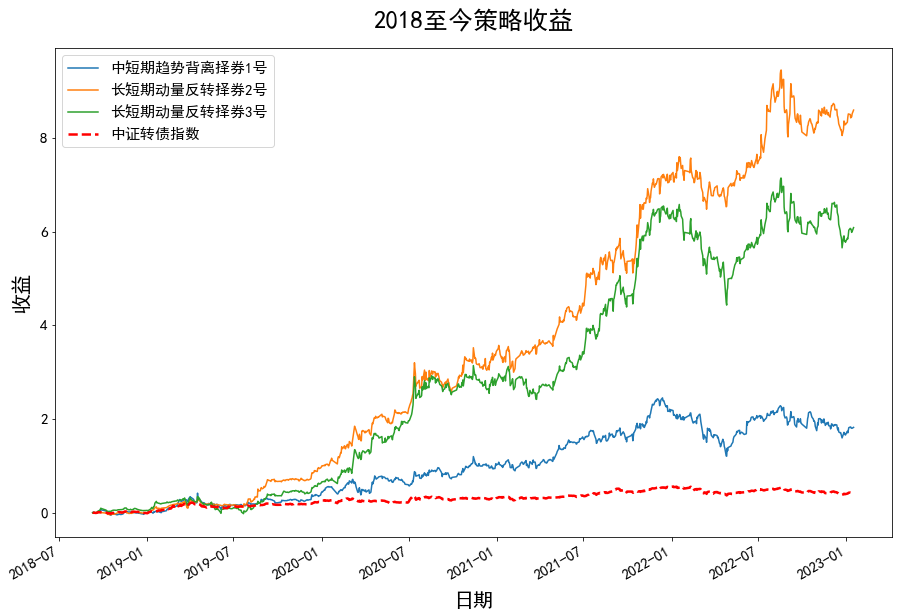

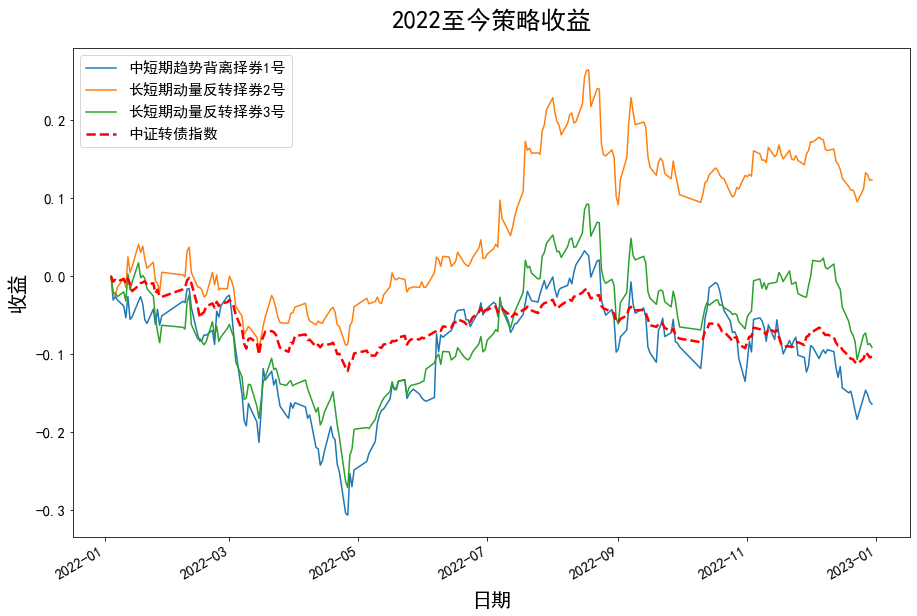

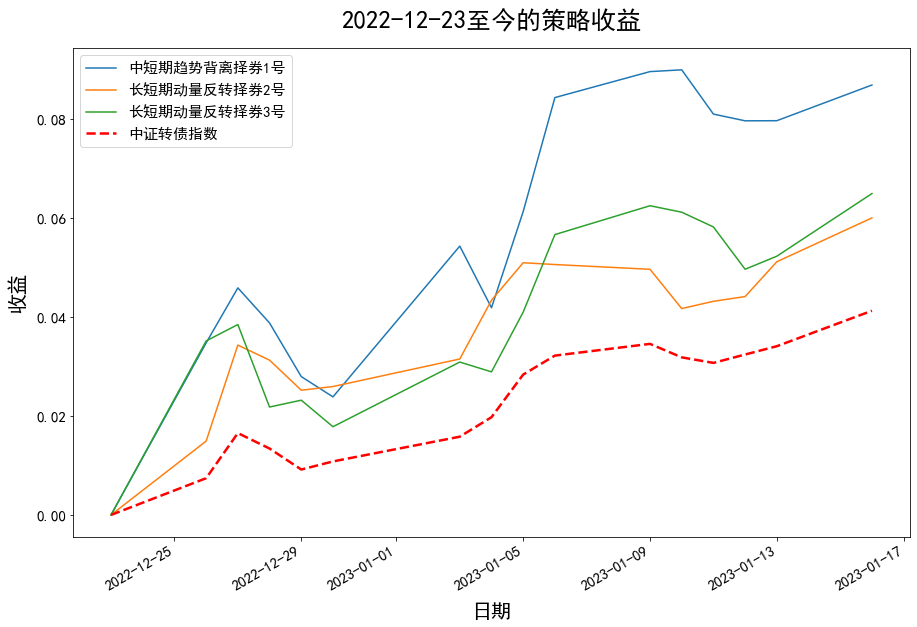

In [499]:
Res_df = Cal_comparison(strat_list=[hld_rev,hld_pbroe1,hld_pbroe],strat_name_list = ['中短期趋势背离择券1号','长短期动量反转择券2号','长短期动量反转择券3号'],date_range=['20221223','20230118'])


In [500]:
Res_df

中证转债指数 中短期趋势背离择券1号 长短期动量反转择券2号 长短期动量反转择券3号
Ret (D)            0.7%        0.7%        0.8%        1.2%
Ret (W)            0.7%       -0.2%        1.0%        0.2%
Ret (M)            1.5%        2.0%        1.5%       -3.8%
Ret (Q)           -0.8%       -7.4%        3.5%       -1.6%
Ret (Y)           -6.7%      -12.1%       17.0%       -3.7%
Ret (MTD)          3.0%        6.2%        3.3%        4.6%
Ret (YTD)          3.0%        6.2%        3.3%        4.6%
Ret (Y)           -6.3%       -7.2%       18.1%       -0.2%
Vol (Y)           10.0%       33.2%       22.6%       26.4%
Sharpe (Y)       -63.0%      -21.8%       79.9%       -0.9%
MaxDrawDown (Y)   12.2%       31.0%       13.7%       28.3%
VaR95% (Y)         1.0%        3.1%        1.9%        2.5%
VaR99% (Y)         0.8%        2.4%        1.4%        2.0%

# 其他实验

In [34]:
def uni(x):
    from scipy.stats import norm
    rpct = x.rank(pct=True)
    return norm.ppf(rpct - rpct.min()/2)

In [35]:
daily_ret = hld_rev[(hld_rev.tday == datetime.datetime(2022,12,21)) & (~hld_rev['ma5/ma20_daily_rank'].isna())].sort_values('Close_ret_adj',ascending=False)
daily_ret['Norm_ret'] = uni(daily_ret['Close_ret_adj'])
#daily_ret['hld_ret'] = daily_ret.hld * daily_ret.Norm_ret

<AxesSubplot:>

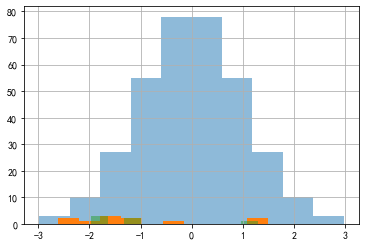

In [36]:
daily_ret.Norm_ret.hist(bins = 10,alpha = 0.5)
(daily_ret.hld * daily_ret.Norm_ret).hist(bins = 10)
(daily_ret[daily_ret.hld_count == 1].Norm_ret).hist(bins = 10,alpha=0.5)

<AxesSubplot:>

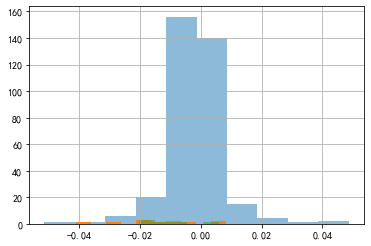

In [37]:
daily_ret.Close_ret_adj.hist(bins = 10,alpha = 0.5)
(daily_ret.hld * daily_ret.Close_ret_adj).hist(bins = 10)
(daily_ret[daily_ret.hld_count == 1].Close_ret_adj).hist(bins = 5,alpha = 0.5)

In [38]:
daily_ret[daily_ret.hld_count == 1].sort_values('Close_ret_adj',ascending=False)

Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
122742      122742     256820 2022-12-21             0.014451   True  True   
205584      205584     337394 2022-12-21             0.005780   True  True   
63617        63617     183924 2022-12-21             0.002890   True  True   
238768      238768     447470 2022-12-21             0.023121    NaN  True   
78725        78725     204365 2022-12-21             0.017341   True  True   
139471      139471     271202 2022-12-21             0.008671   True  True   

        hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
122742        1.0            2.0       0.005954  128079.SZ     英联转债  0.005954   
205584        1.0            5.0      -0.009627  123085.SZ     万顺转2 -0.009627   
63617         1.0            6.0      -0.009988  123012.SZ     万顺转债 -0.009988   
238768        1.0            3.0      -0.017153  127064.SZ     杭氧转债 -0.017153   
78725         1.0            7.0      -0.017677  110048.SH     福能转债 -0.017677   
139471        1.0            1.0      -0.020439  128091.SZ     新天转债 -0.020439   

        Norm_ret  
122742  1.299881  
205584 -1.266869  
63617  -1.299881  
238768 -1.762205  
78725  -1.797512  
139471 -1.967436

In [39]:
daily_ret.index = np.arange(daily_ret.shape[0])

<BarContainer object of 11 artists>

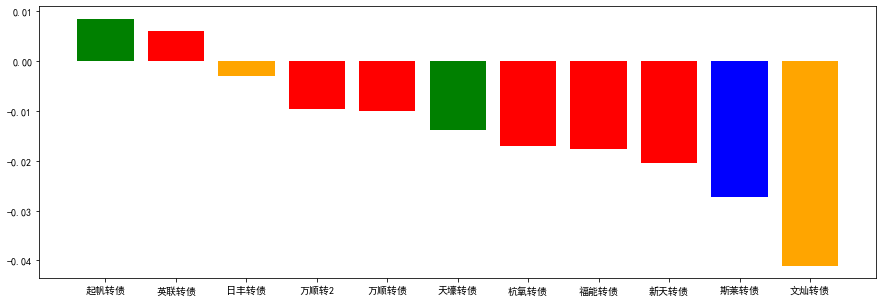

In [40]:
m = {1:'red',2:'orange',3:'green',4:'blue',5:'purple'}
daily_ret_hld = daily_ret[~daily_ret.hld.isna()].sort_values('Close_ret_adj',ascending=False)
#[['SecuAbbr','Close_ret_adj']].plot(kind='pie')
#daily_ret_hld[['SecuAbbr','Close_ret_adj']].set_index('SecuAbbr').plot(kind='bar')
plt.figure(figsize=(15,5))
plt.bar(daily_ret_hld.SecuAbbr,daily_ret_hld.Close_ret_adj,color = daily_ret_hld.hld_count.map(m))

<BarContainer object of 11 artists>

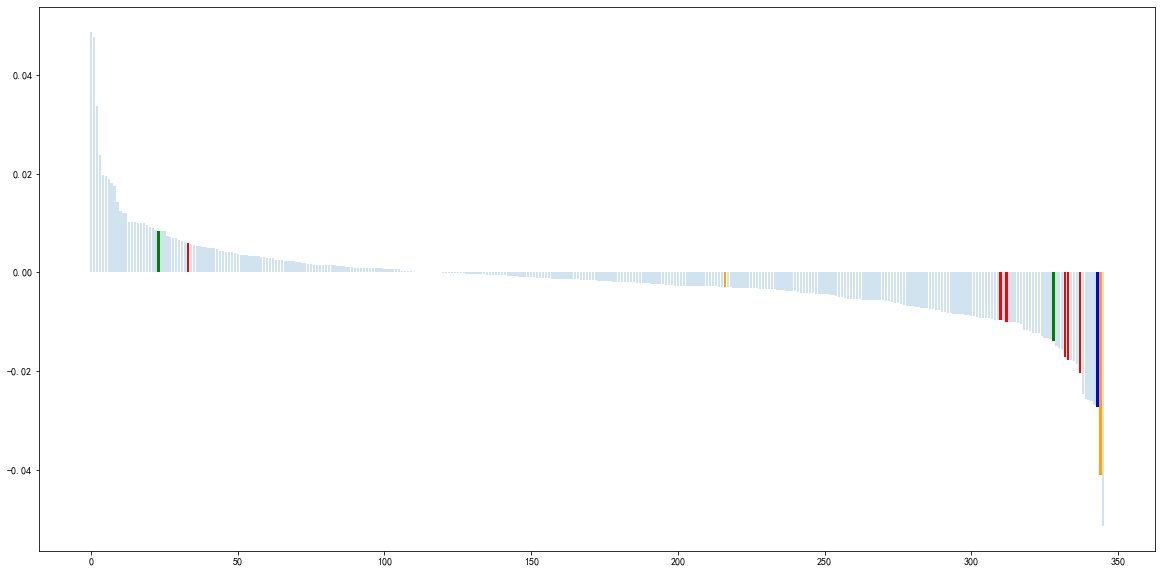

In [41]:
plt.figure(figsize=(20,10))
plt.bar(daily_ret.index,daily_ret.Close_ret_adj,alpha=0.2)
plt.bar(daily_ret_hld.index,daily_ret_hld.Close_ret_adj,color = daily_ret_hld.hld_count.map(m))

3. 全市场分析

In [277]:
cr = daily_ret.Close_ret_adj
daily_ret_brief = daily_ret[ (cr > cr.quantile(0.98)) | (cr < cr.quantile(0.02))
                            | ((cr > cr.quantile(0.49)) & (cr < cr.quantile(0.51))
                              )].sort_values('Close_ret_adj',ascending=False)


<BarContainer object of 2 artists>

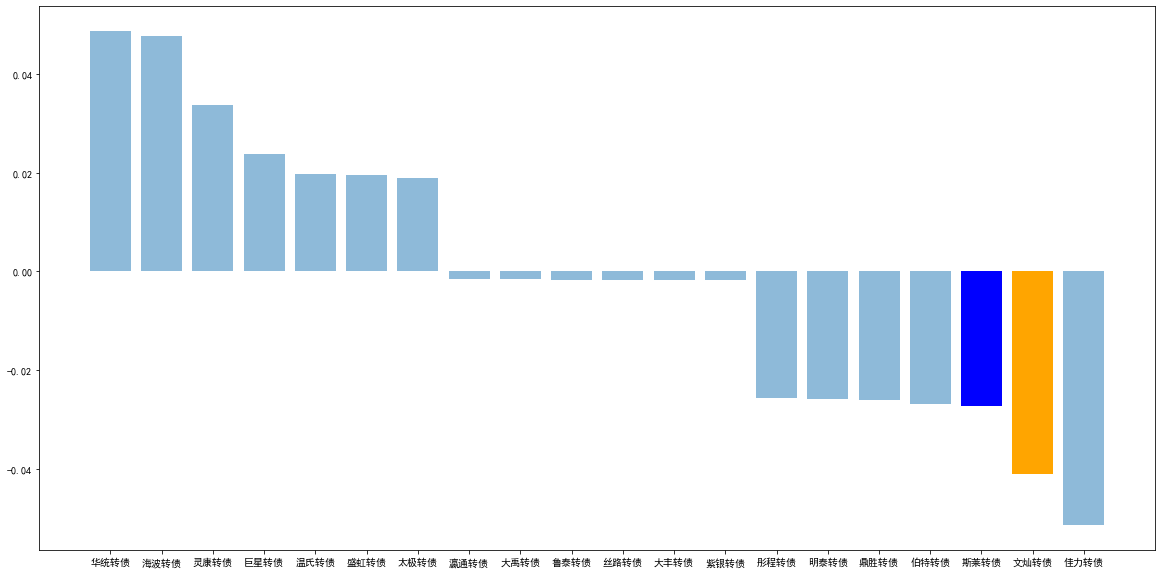

In [278]:
daily_ret_brief.index = np.arange(daily_ret_brief.shape[0])
plt.figure(figsize=(20,10))
plt.bar(daily_ret_brief.SecuAbbr,daily_ret_brief.Close_ret_adj,alpha=0.5)
daily_ret_brief_hld = daily_ret_brief[~daily_ret_brief.hld.isna()].sort_values('Close_ret_adj',ascending=False)
plt.bar(daily_ret_brief_hld.index,daily_ret_brief_hld.Close_ret_adj,color = daily_ret_brief_hld.hld_count.map(m))

In [279]:
daily_ret.sort_values('Close_ret_adj',ascending=False)

Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
0        156011     289424 2022-12-21             0.971098    NaN   NaN   
1        200850     335415 2022-12-21             0.988439    NaN   NaN   
2        200138     335139 2022-12-21             0.893064    NaN   NaN   
3        235775     443358 2022-12-21             0.890173    NaN   NaN   
4        217239     358694 2022-12-21             0.953757    NaN   NaN   
..          ...        ...        ...                  ...    ...   ...   
341      103821     223692 2022-12-21             0.034682    NaN   NaN   
342      224511     382130 2022-12-21             0.563584    NaN   NaN   
343      189301     320195 2022-12-21             0.057803    NaN  True   
344      109862     233277 2022-12-21             0.040462    NaN  True   
345      180867     309938 2022-12-21             0.979769    NaN   NaN   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
0          NaN            NaN       0.048705  128106.SZ     华统转债       NaN   
1          NaN            NaN       0.047726  123080.SZ     海波转债       NaN   
2          NaN            NaN       0.033615  113610.SH     灵康转债       NaN   
3          NaN            NaN       0.023837  113648.SH     巨星转债       NaN   
4          NaN            NaN       0.019760  123107.SZ     温氏转债       NaN   
..         ...            ...            ...        ...      ...       ...   
341        NaN            NaN      -0.026057  113534.SH     鼎胜转债       NaN   
342        NaN            NaN      -0.026802  113626.SH     伯特转债       NaN   
343        4.0           17.0      -0.027309  123067.SZ     斯莱转债 -0.027309   
344        2.0            3.0      -0.041044  113537.SH     文灿转债 -0.041044   
345        NaN            NaN      -0.051432  113597.SH     佳力转债       NaN   

     Norm_ret  
0    2.979184  
1    2.624779  
2    2.445856  
3    2.322032  
4    2.226039  
..        ...  
341 -2.226039  
342 -2.322032  
343 -2.445856  
344 -2.624779  
345 -2.979184  

[346 rows x 13 columns]

In [103]:
sql = '''
SELECT 
S_INFO_WINDCODE,TRADE_DT,S_DQ_OPEN Open,S_DQ_HIGH High,S_DQ_LOW Low,S_DQ_CLOSE Close
FROM wind.CBIndexEODPrices
where S_INFO_WINDCODE = '000832.CSI'
and TRADE_DT >= '20180101'
order by TRADE_DT
'''

Weight_index = pd.read_sql(sql,conn_wd)
Weight_index['TRADE_DT'] = pd.to_datetime(Weight_index['TRADE_DT'])
index = Weight_index[['TRADE_DT','CLOSE']]

In [104]:
index

TRADE_DT     CLOSE
0    2018-01-02  285.9860
1    2018-01-03  289.6659
2    2018-01-04  290.1870
3    2018-01-05  292.8428
4    2018-01-08  292.9719
...         ...       ...
1204 2022-12-16  396.3888
1205 2022-12-19  392.9201
1206 2022-12-20  391.2334
1207 2022-12-21  391.1206
1208 2022-12-22  389.4211

[1209 rows x 2 columns]

3. 筛选各券分析

In [202]:
beg_dt = hld_rev.tday.min()

In [203]:
sql = '''
SELECT 
a.InnerCode, a.TradingDay as tday,a.ClosePrice,a.PrevClosePrice,a.OpenPrice,a.HighPrice,a.LowPrice, a.TurnoverRate, a.ConvertPremiumRate, a.ChangePCT,
 b.ConvTermStartDate, conv.RemainingAmount, per.ChangePCT as ChangePCT_stock, BackwardPrice, per.ClosePrice as ClosePrice_stock, a.YrMat
FROM Bond_ConBDExchangeQuote a
left join Bond_ConBDBasicInfo b on a.InnerCode = b.InnerCode
left join Bond_ConBDConvertInfo conv on a.InnerCode = conv.InnerCode and a.TradingDay = conv.EndDate and conv.EventType = 1
left join SecuMain on b.SecuCode = SecuMain.SecuCode and b.SecuAbbr = SecuMain.SecuAbbr
left join DZ_PerformanceData per on SecuMain.InnerCode = per.InnerCode and per.TradingDay = a.TradingDay
WHERE a.TradingDay>='{}'
and b.BondForm = 1
order by a.InnerCode, a.TradingDay
'''

data = pd.read_sql(sql.format(beg_dt), conn_jy)
data = data.sort_values(['InnerCode','tday'])

In [237]:
data['MA5'] = data.groupby('InnerCode').ClosePrice.apply(lambda x: x.rolling(5).mean())
data['MA20'] = data.groupby('InnerCode').ClosePrice.apply(lambda x: x.rolling(20).mean())
data['MA20S'] = data.groupby('InnerCode').ClosePrice_stock.apply(lambda x: x.rolling(20).mean())
data['MA40S'] = data.groupby('InnerCode').ClosePrice_stock.apply(lambda x: x.rolling(40).mean())

In [251]:
def draw_bs(InnerCode):
    data[data.InnerCode == i][['ClosePrice','MA5','MA20','tday'
                                   ]].set_index('tday').plot(figsize=(25,5))
    data[data.InnerCode == i][['ClosePrice_stock','MA20S','MA40S','tday'
                                   ]].set_index(
        'tday').plot(figsize=(25,5))
    
    plt.show()

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
30      221295     370882 2022-12-21             0.083815    NaN  True   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr  ret_hld  \
30        3.0            6.0        0.00846  111000.SH     起帆转债  0.00846   

    Norm_ret  
30  1.393268  


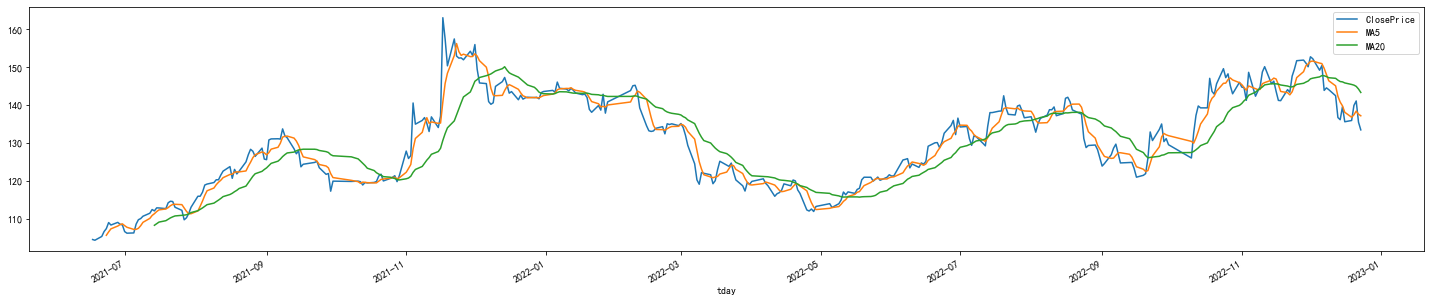

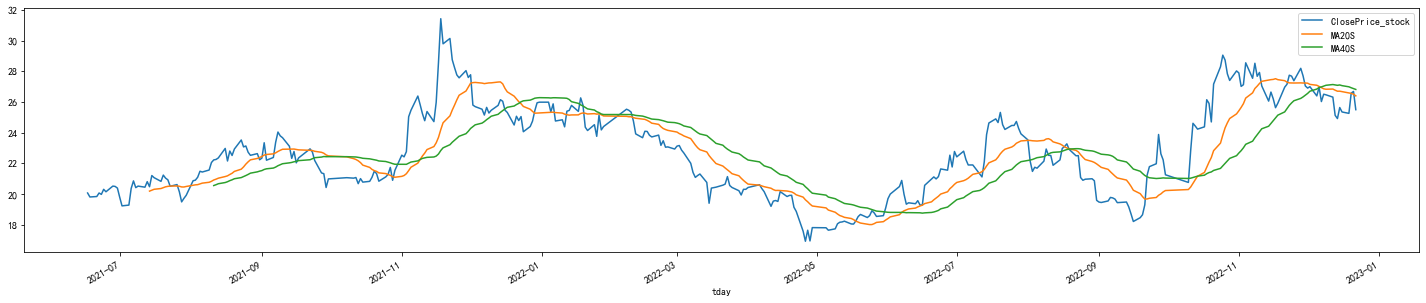

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
43      122110     256820 2022-12-21             0.014451   True  True   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
43        1.0            2.0       0.005954  128079.SZ     英联转债  0.005954   

    Norm_ret  
43  1.192044  


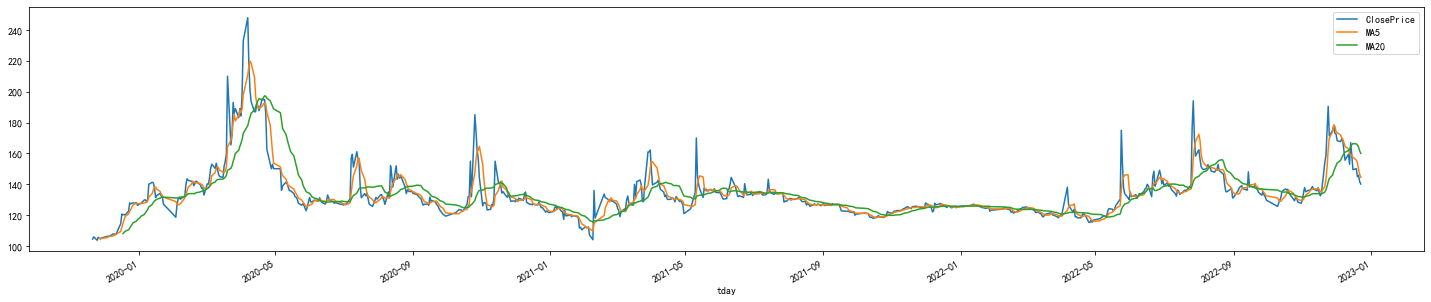

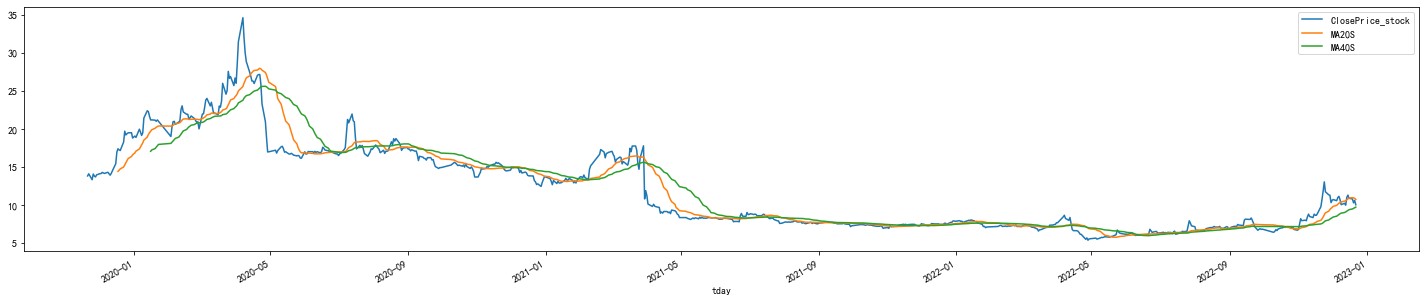

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
233      215753     357191 2022-12-21             0.031792    NaN  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
233        2.0            2.0      -0.003008  128145.SZ     日丰转债 -0.003008   

     Norm_ret  
233 -0.321292  


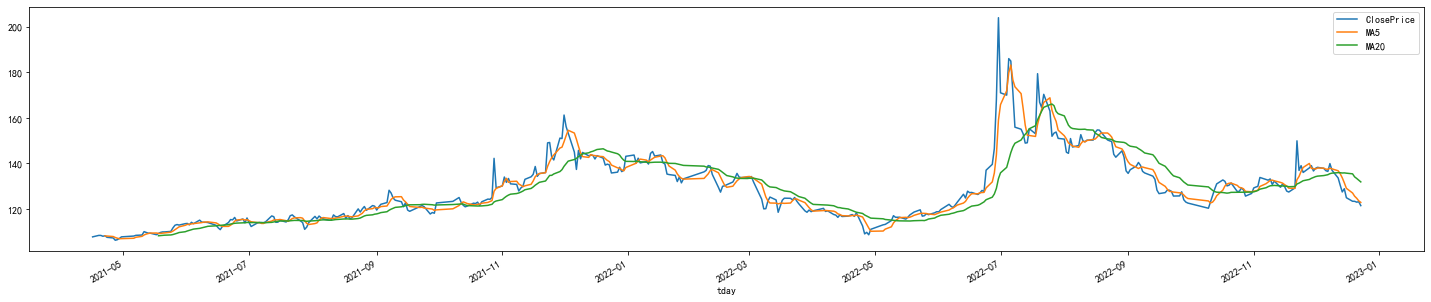

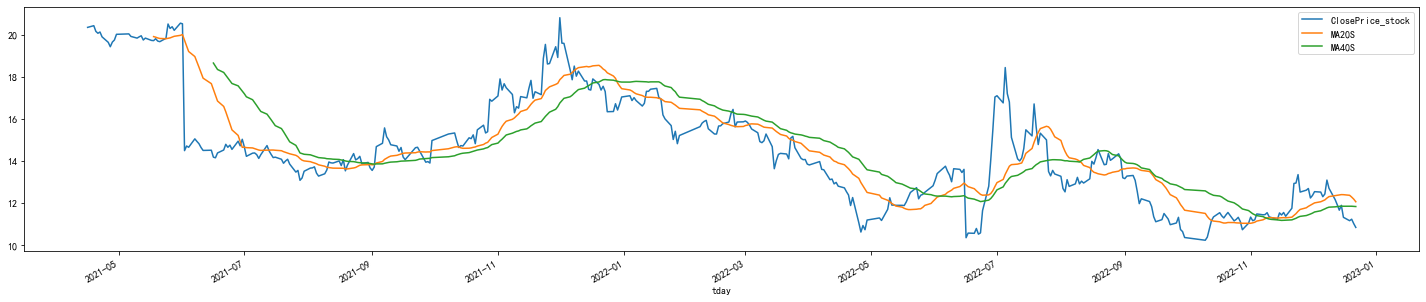

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
332      203848     337394 2022-12-21              0.00578   True  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
332        1.0            5.0      -0.009627  123085.SZ     万顺转2 -0.009627   

     Norm_ret  
332  -1.23412  


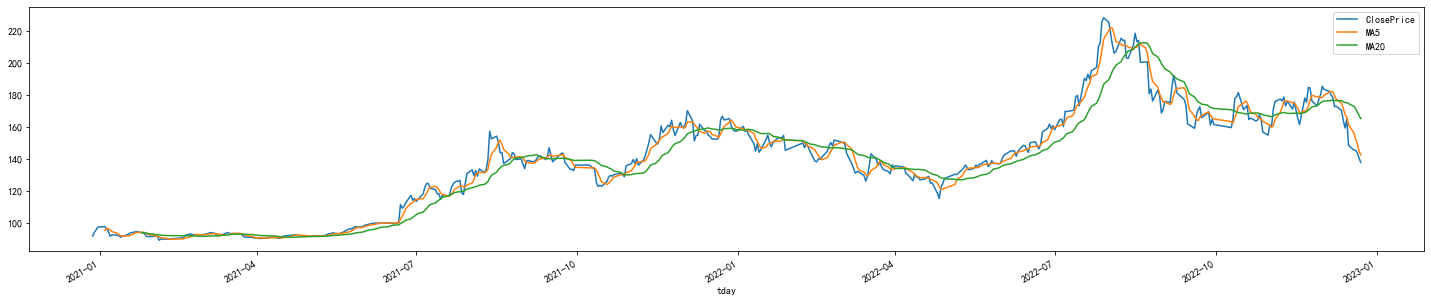

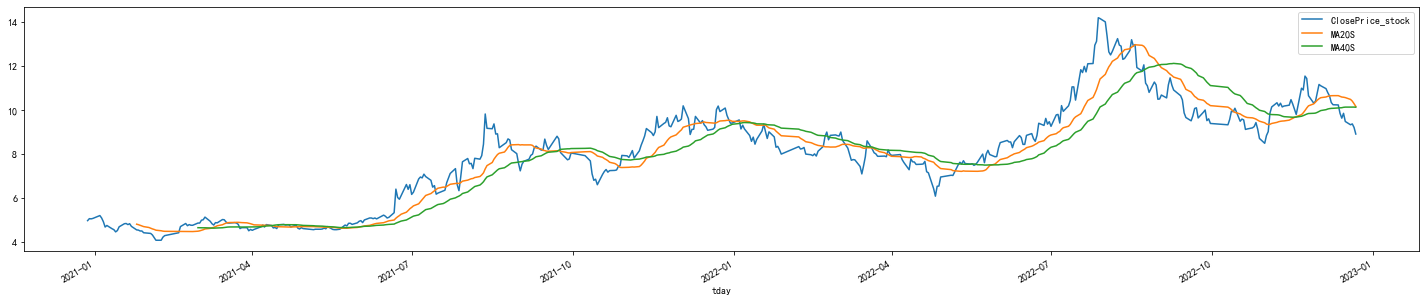

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
334       63361     183924 2022-12-21              0.00289   True  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
334        1.0            6.0      -0.009988  123012.SZ     万顺转债 -0.009988   

     Norm_ret  
334 -1.263431  


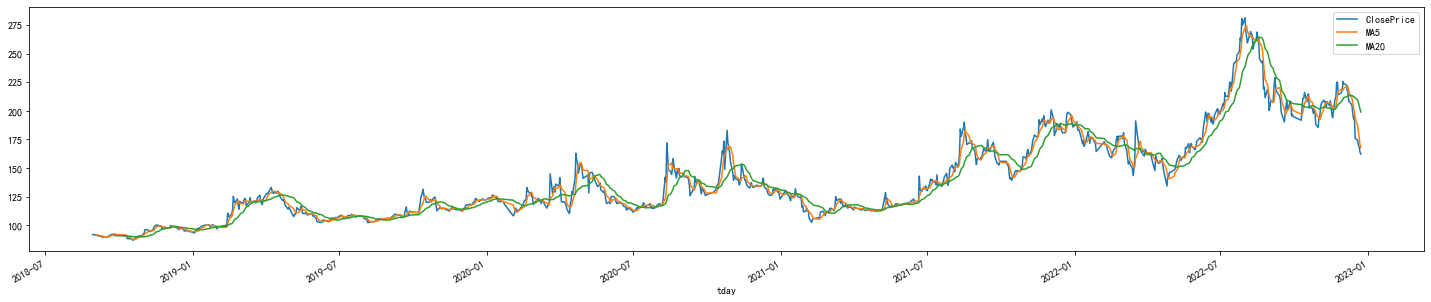

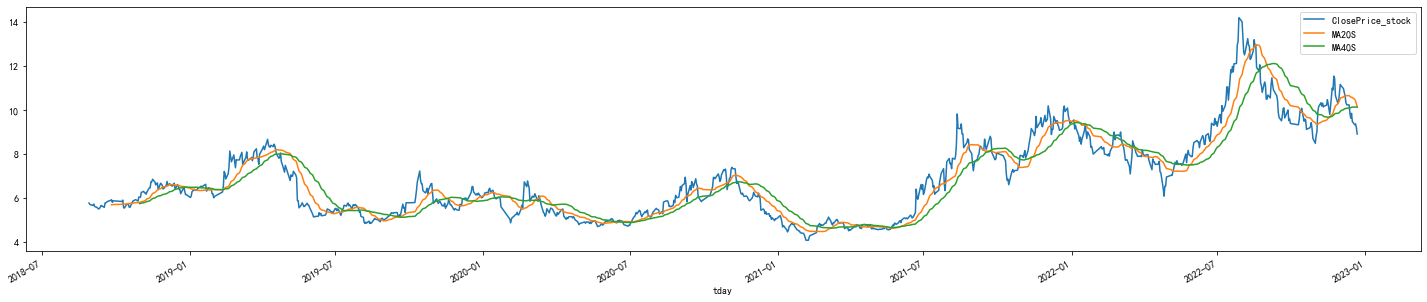

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
351      207878     339882 2022-12-21             0.049133    NaN  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
351        3.0            8.0      -0.013859  123092.SZ     天壕转债 -0.013859   

     Norm_ret  
351 -1.574891  


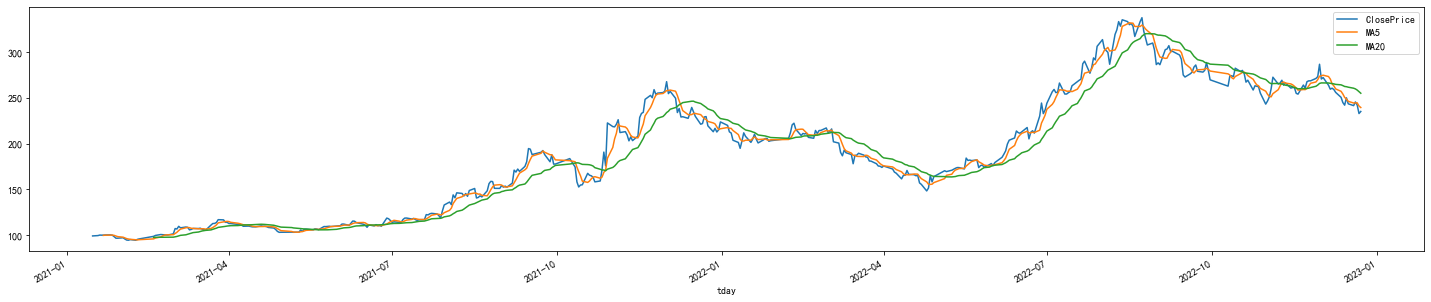

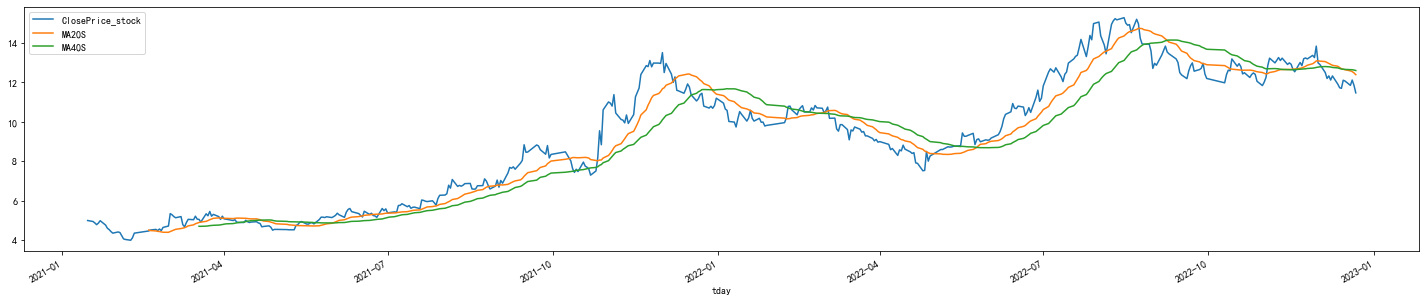

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
357      235824     447470 2022-12-21             0.023121    NaN  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
357        1.0            3.0      -0.017153  127064.SZ     杭氧转债 -0.017153   

     Norm_ret  
357  -1.73292  


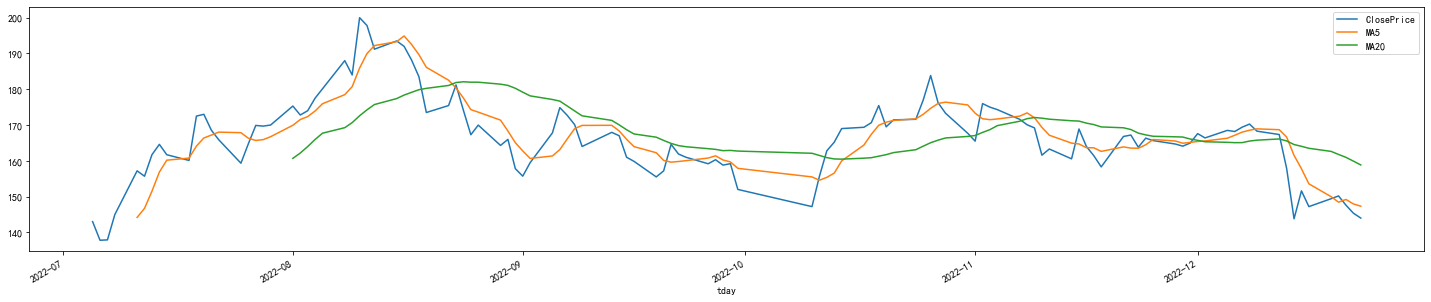

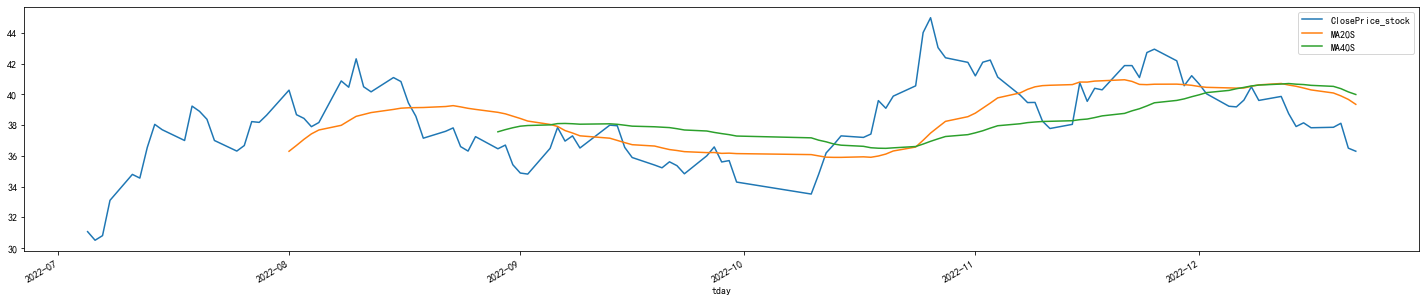

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
358       78381     204365 2022-12-21             0.017341   True  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
358        1.0            7.0      -0.017677  110048.SH     福能转债 -0.017677   

     Norm_ret  
358 -1.763905  


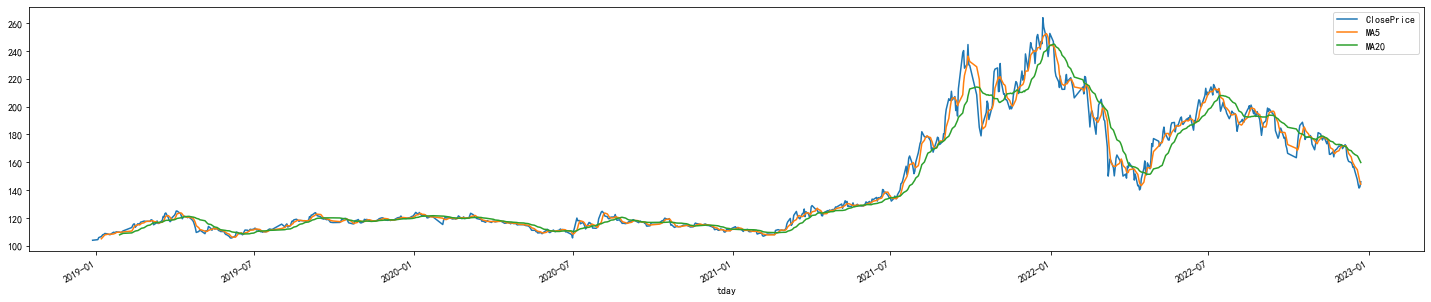

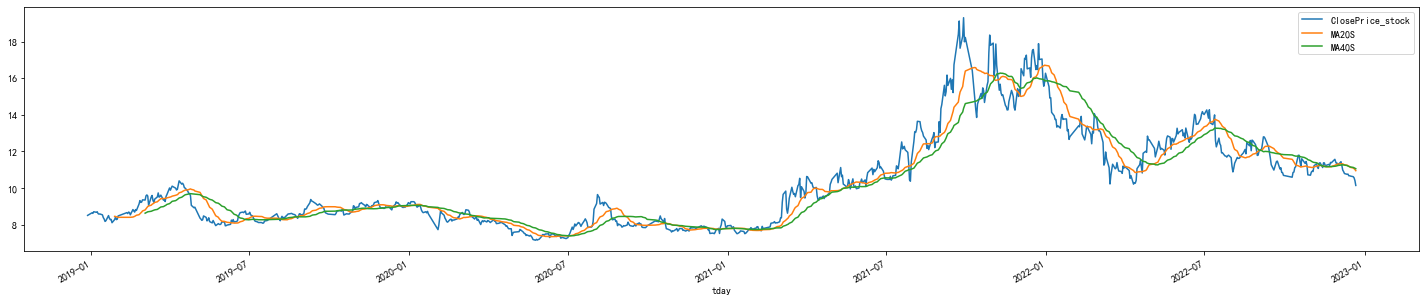

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
363      138671     271202 2022-12-21             0.008671   True  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
363        1.0            1.0      -0.020439  128091.SZ     新天转债 -0.020439   

     Norm_ret  
363 -1.951999  


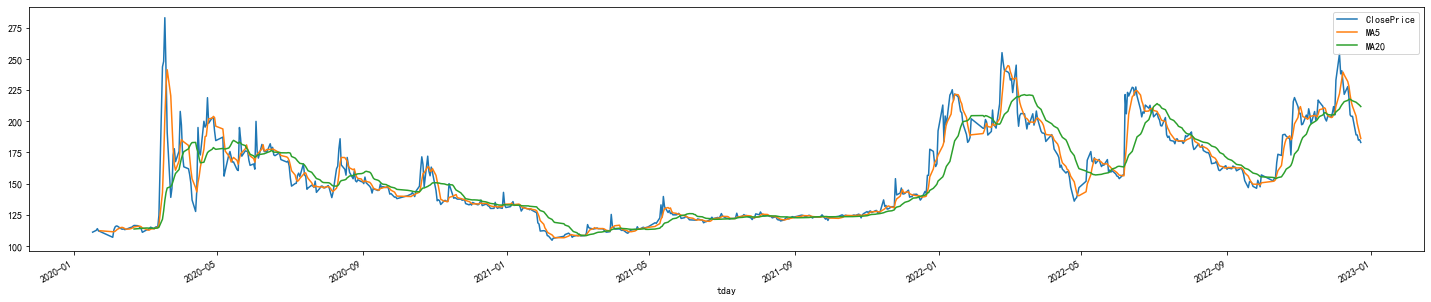

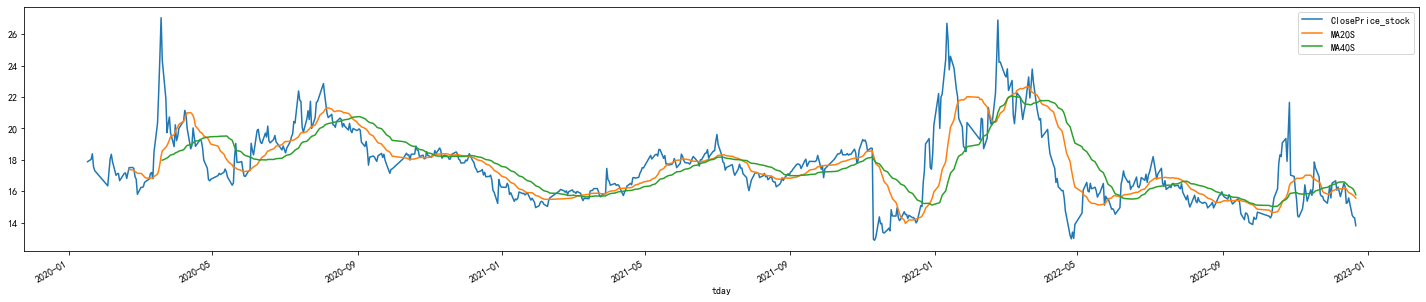

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
369      189301     320195 2022-12-21             0.057803    NaN  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
369        4.0           17.0      -0.027309  123067.SZ     斯莱转债 -0.027309   

     Norm_ret  
369 -2.350132  


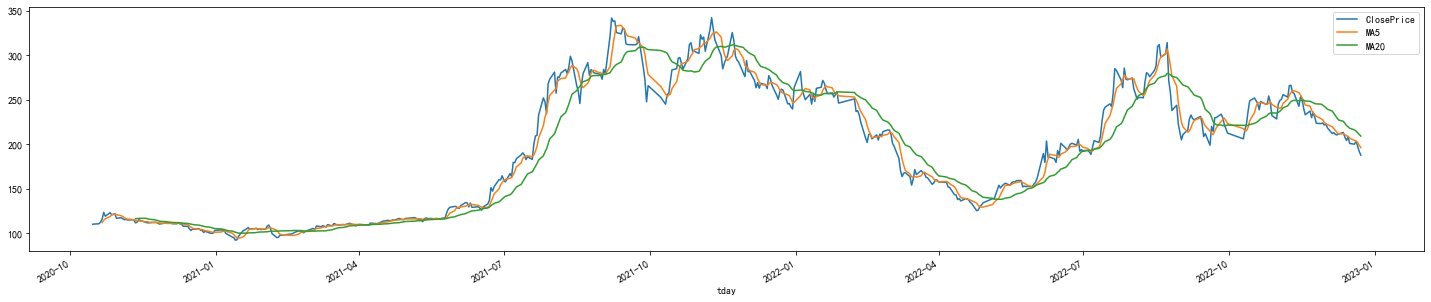

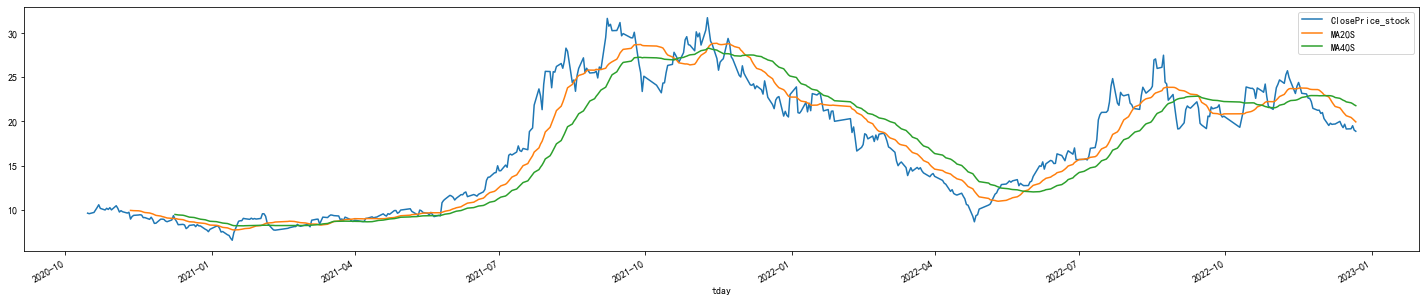

     Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
370      109862     233277 2022-12-21             0.040462    NaN  True   

     hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
370        2.0            3.0      -0.041044  113537.SH     文灿转债 -0.041044   

     Norm_ret  
370 -2.472829  


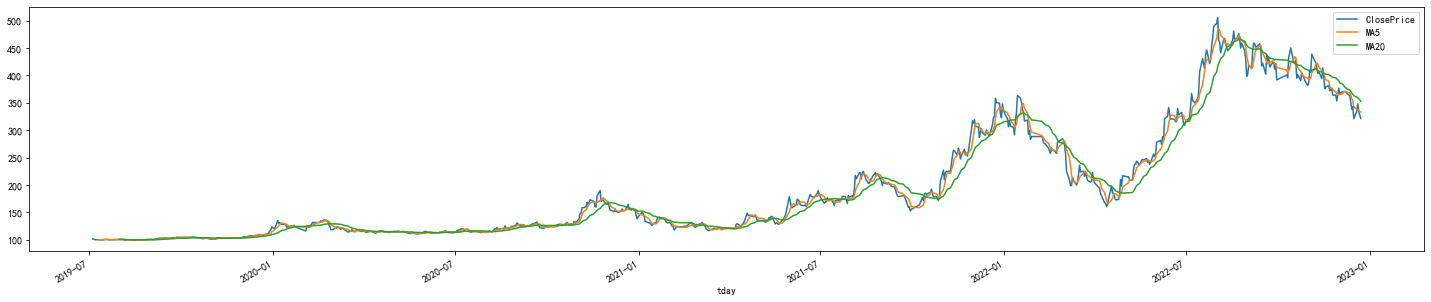

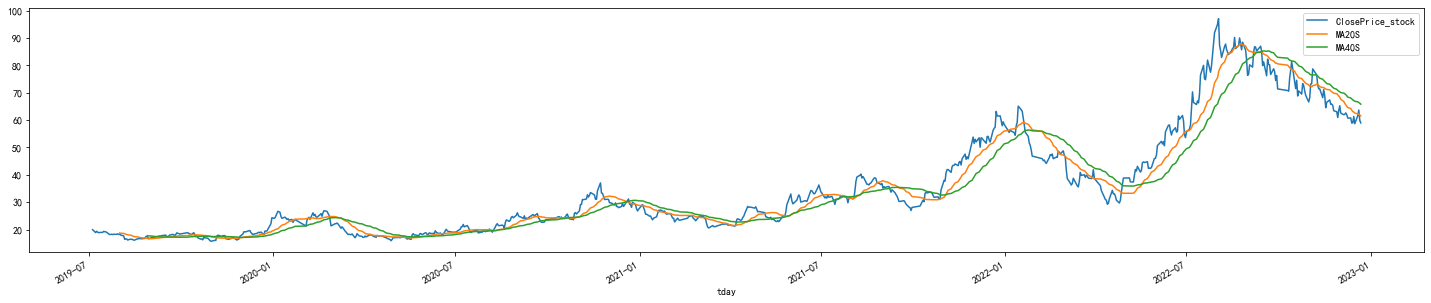

In [252]:
for i in daily_ret_hld.InnerCode:
    print(daily_ret_hld[daily_ret_hld.InnerCode==i])
    draw_bs(i)

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
0      156011     289424 2022-12-21             0.971098    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
0        NaN            NaN       0.048705  128106.SZ     华统转债     NaN   

   Norm_ret  
0  2.979184  


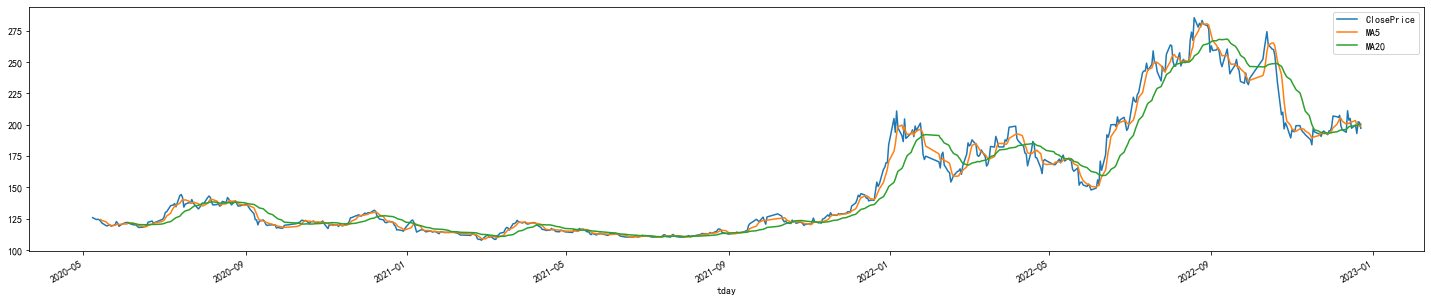

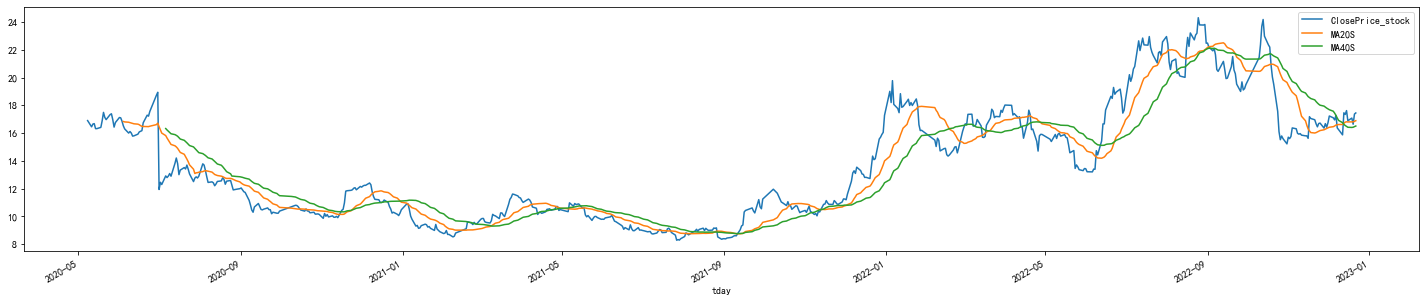

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
1      200850     335415 2022-12-21             0.988439    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
1        NaN            NaN       0.047726  123080.SZ     海波转债     NaN   

   Norm_ret  
1  2.624779  


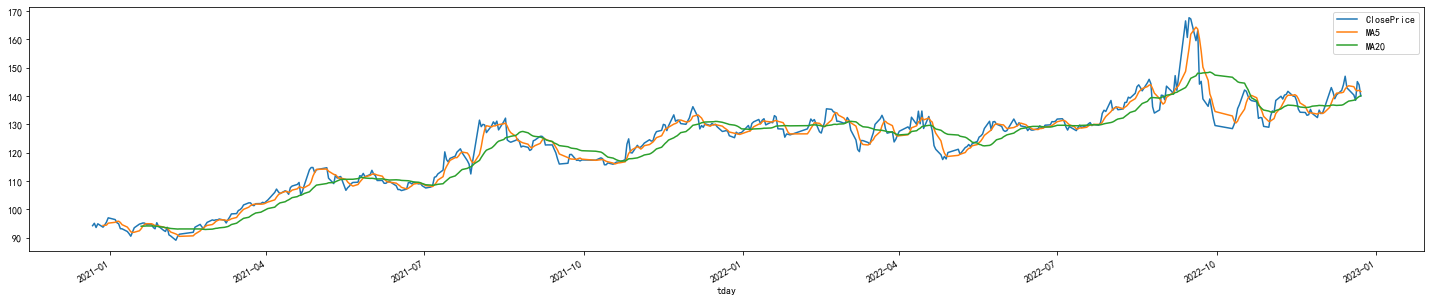

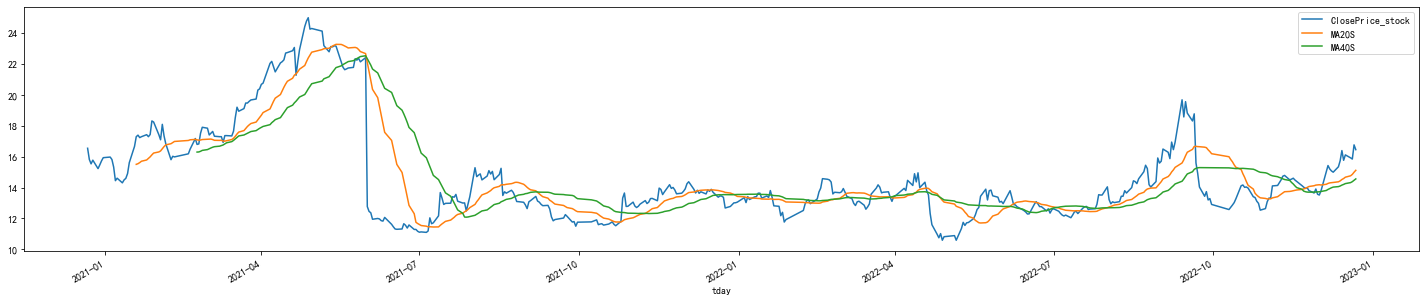

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
2      200138     335139 2022-12-21             0.893064    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
2        NaN            NaN       0.033615  113610.SH     灵康转债     NaN   

   Norm_ret  
2  2.445856  


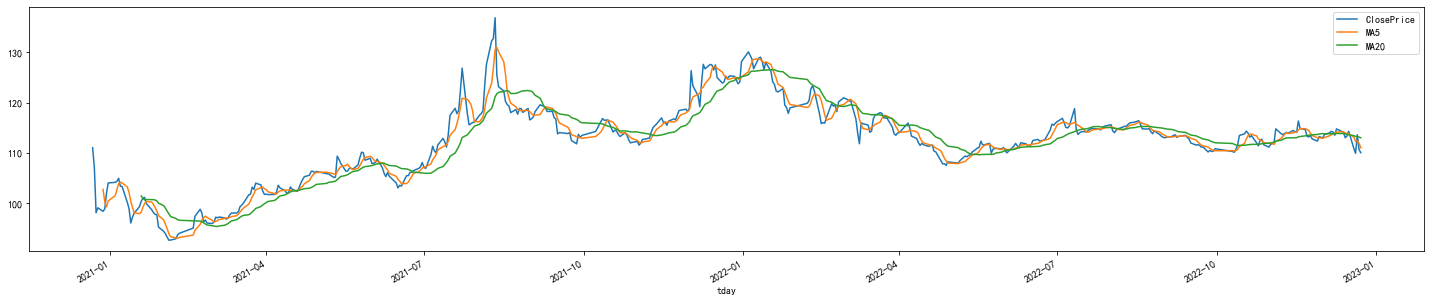

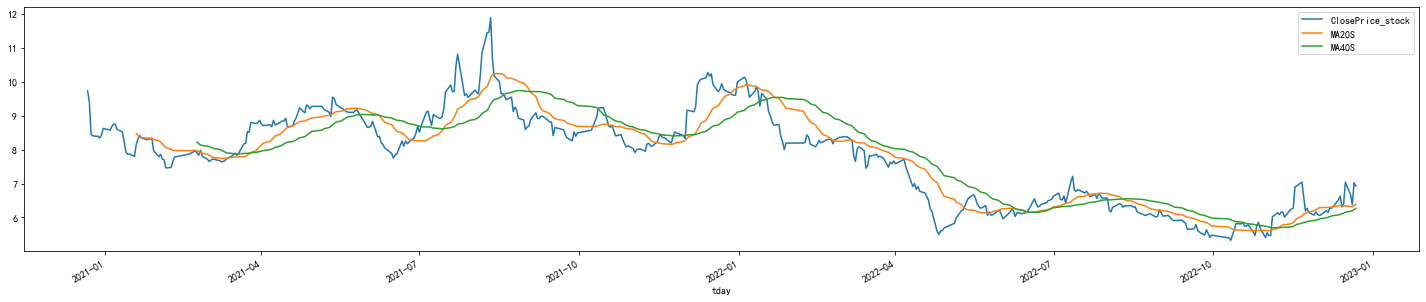

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
3      235775     443358 2022-12-21             0.890173    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
3        NaN            NaN       0.023837  113648.SH     巨星转债     NaN   

   Norm_ret  
3  2.322032  


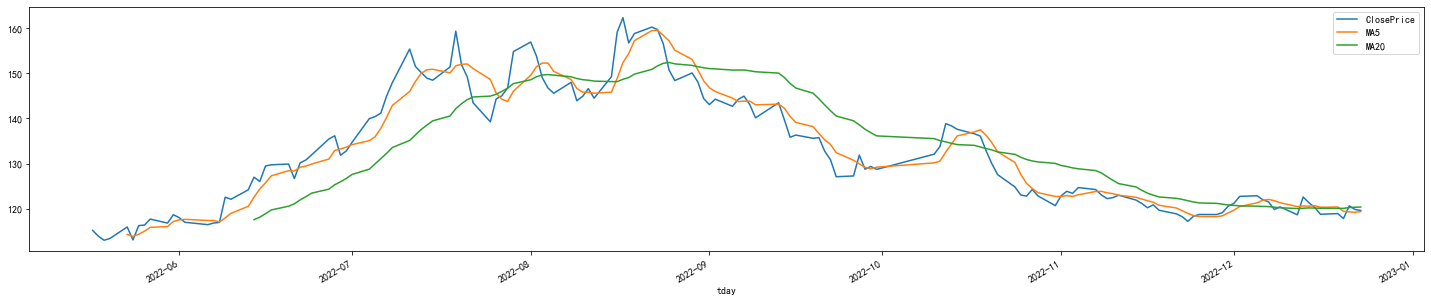

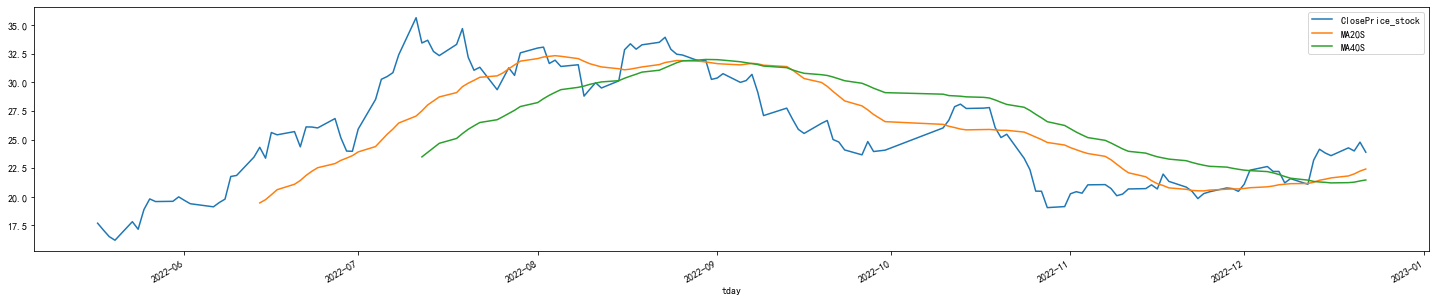

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
4      217239     358694 2022-12-21             0.953757    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
4        NaN            NaN        0.01976  123107.SZ     温氏转债     NaN   

   Norm_ret  
4  2.226039  


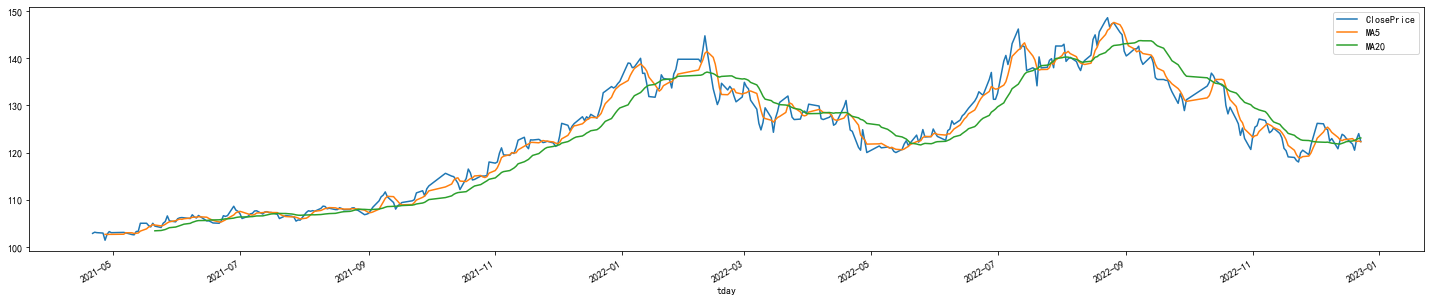

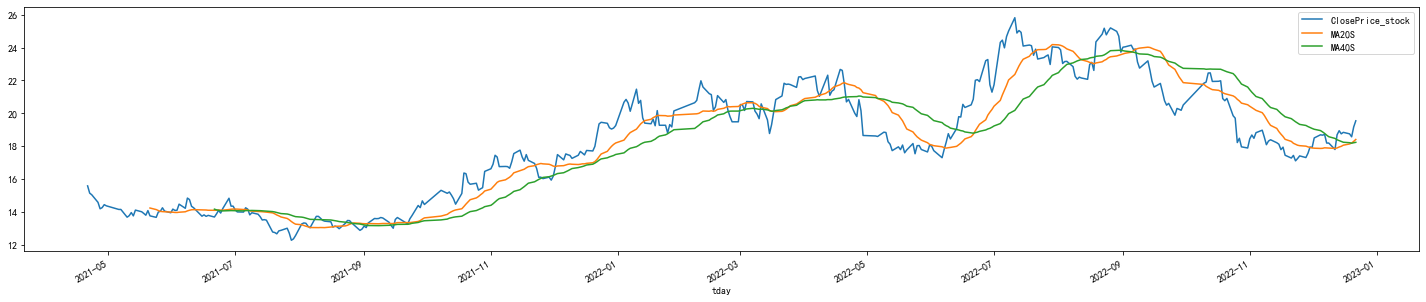

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
5      215452     357190 2022-12-21             0.187861    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
5        NaN            NaN       0.019512  127030.SZ     盛虹转债     NaN   

   Norm_ret  
5  2.147017  


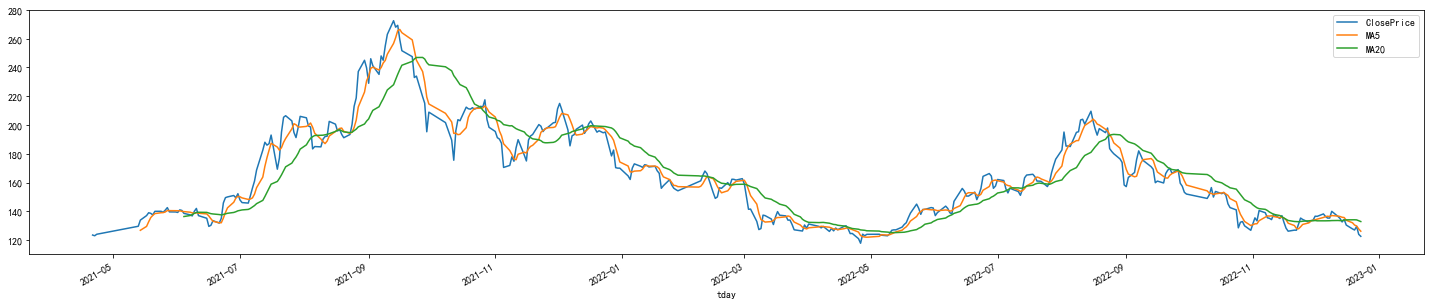

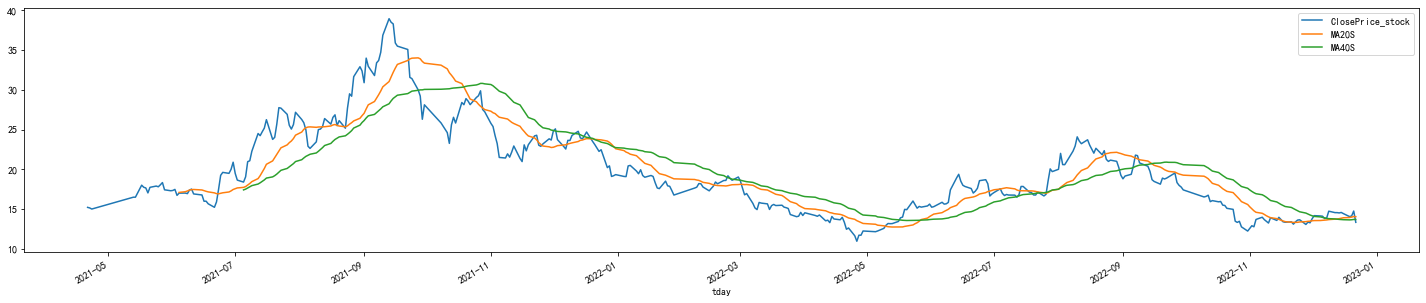

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
6      122757     256821 2022-12-21             0.430636    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
6        NaN            NaN       0.018923  128078.SZ     太极转债     NaN   

   Norm_ret  
6  2.079491  


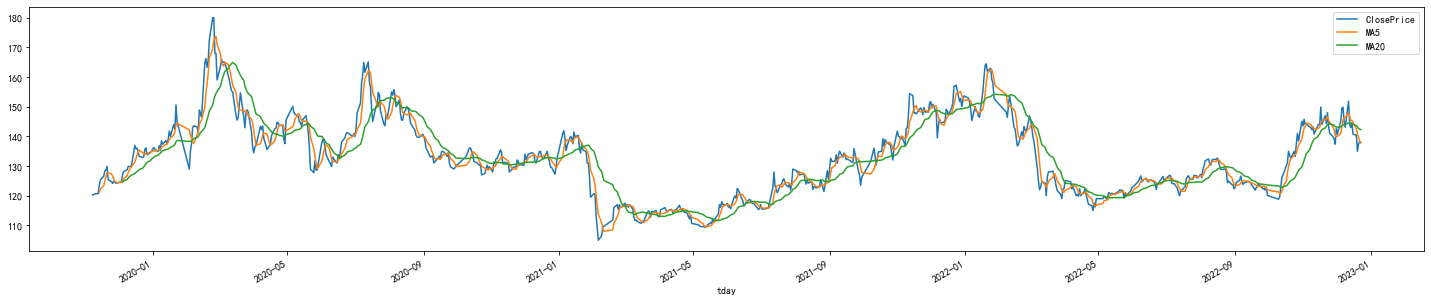

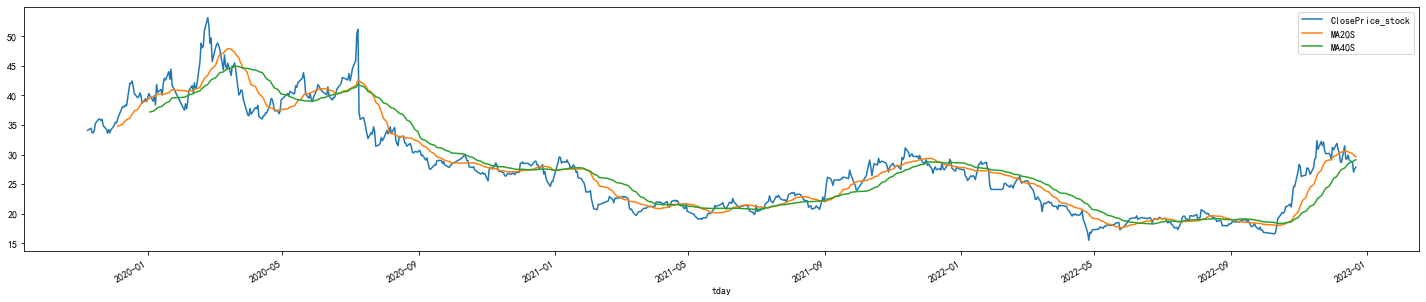

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
7      171012     305225 2022-12-21             0.864162    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
7        NaN            NaN      -0.001624  128118.SZ     瀛通转债     NaN   

   Norm_ret  
7  0.018112  


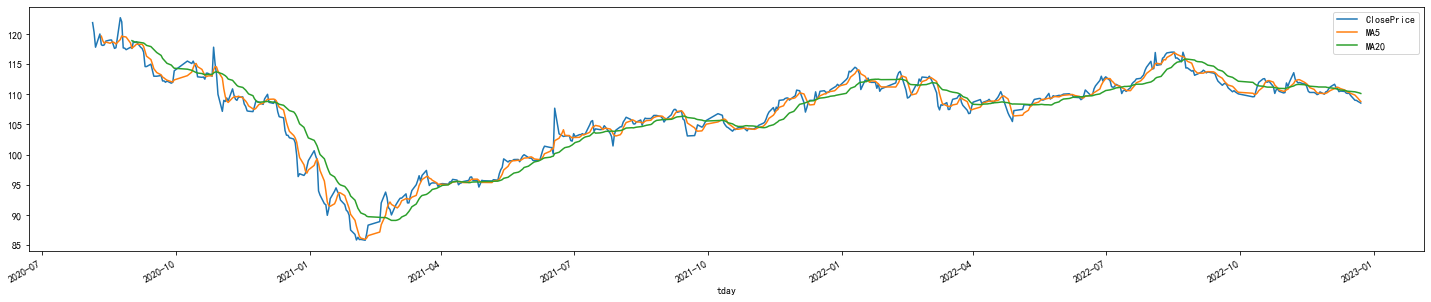

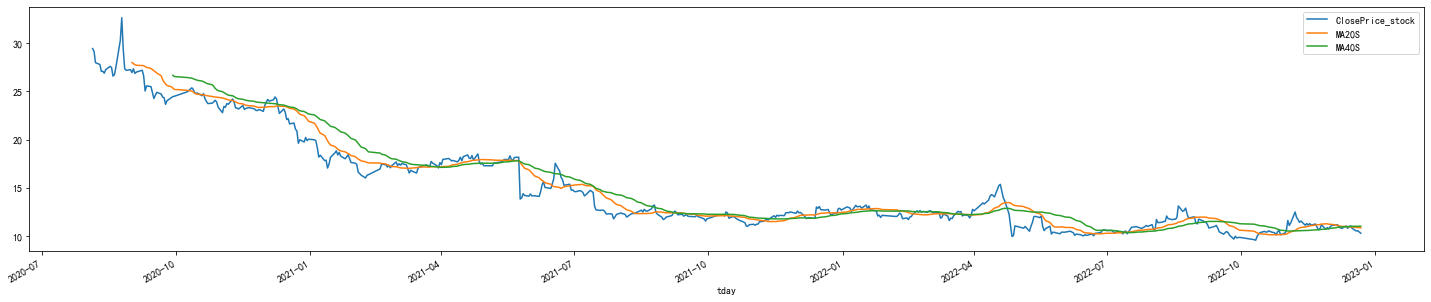

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
8      179961     309484 2022-12-21             0.236994    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
8        NaN            NaN       -0.00166  123063.SZ     大禹转债     NaN   

   Norm_ret  
8  0.010867  


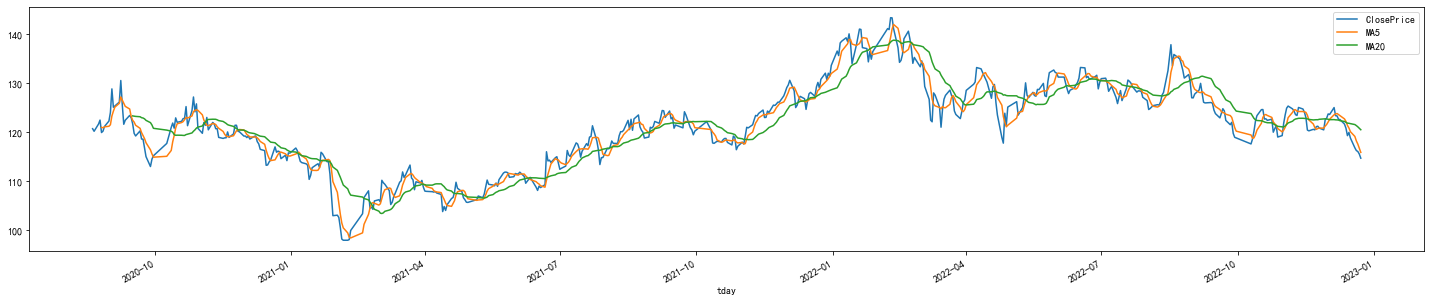

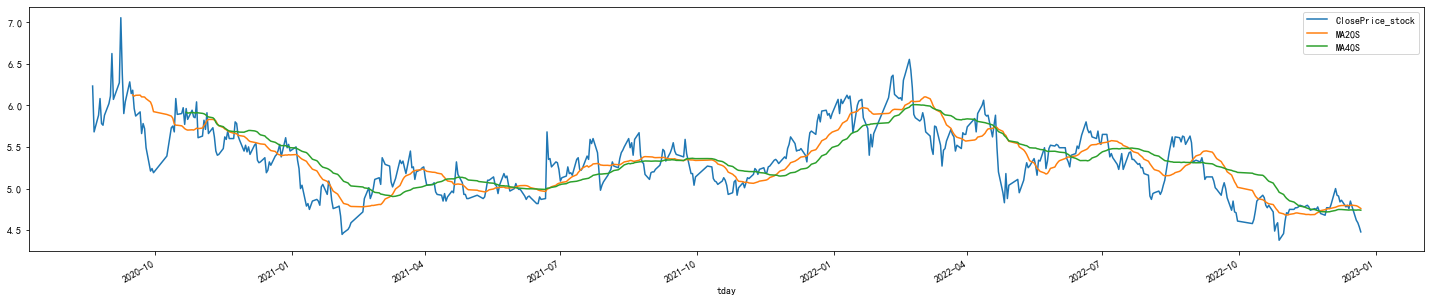

   Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
9      154118     288943 2022-12-21             0.263006    NaN  NaN   

   hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
9        NaN            NaN      -0.001688  127016.SZ     鲁泰转债     NaN   

   Norm_ret  
9  0.003622  


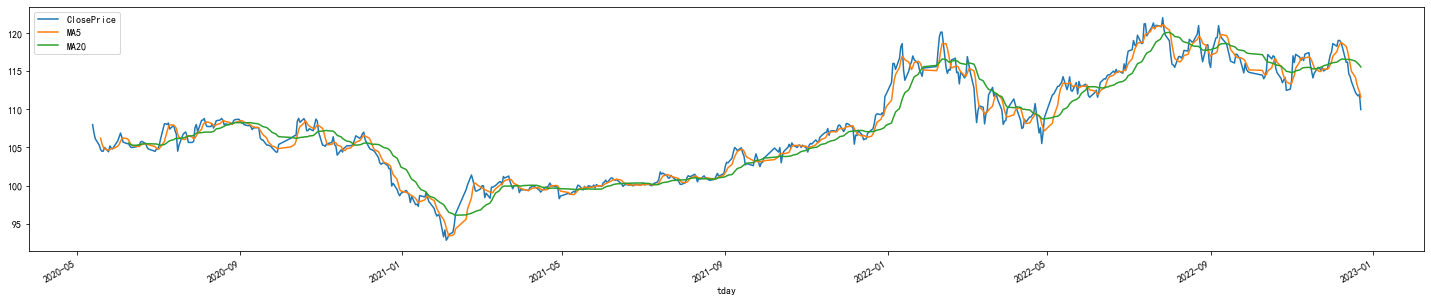

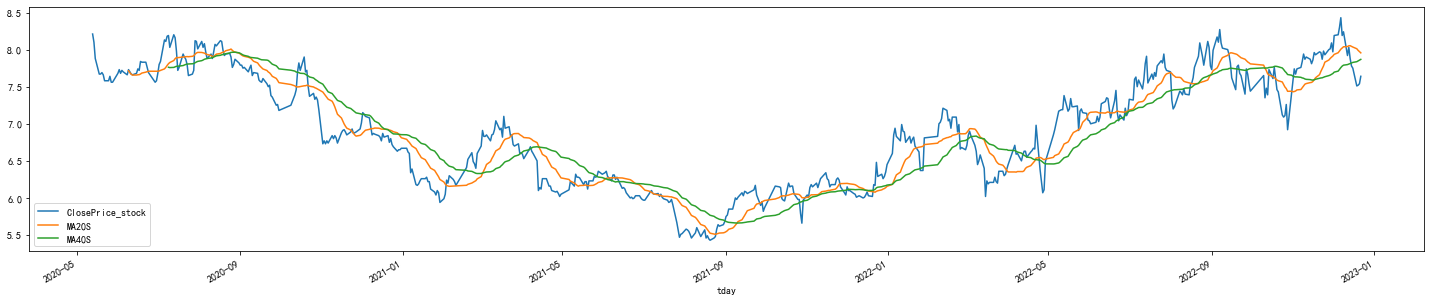

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
10      234349     432773 2022-12-21             0.583815    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
10        NaN            NaN      -0.001764  123138.SZ     丝路转债     NaN   

    Norm_ret  
10 -0.003622  


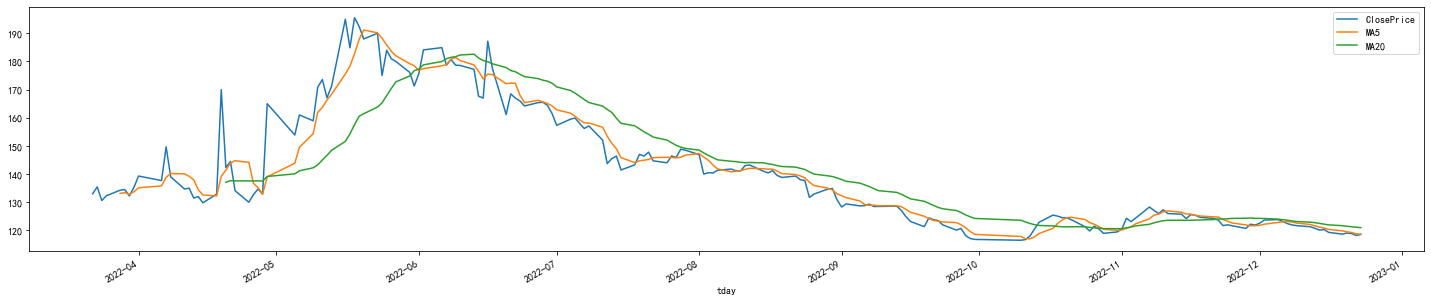

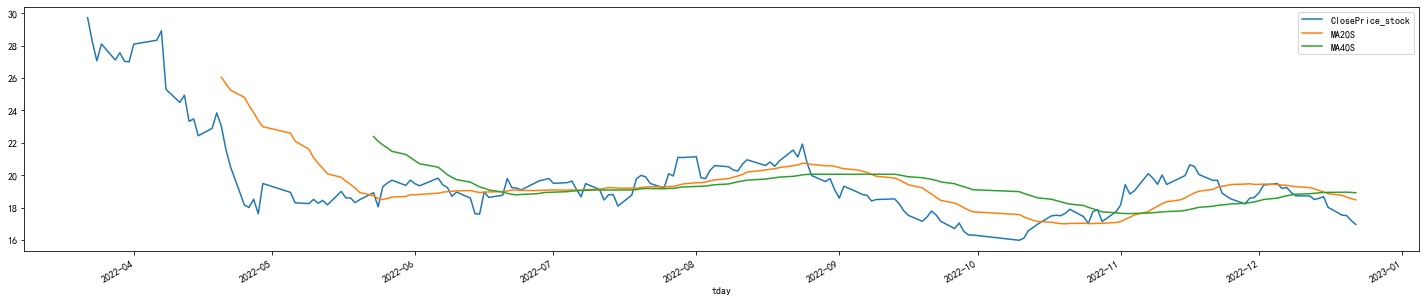

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
11       97714     222206 2022-12-21             0.572254    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
11        NaN            NaN      -0.001783  113530.SH     大丰转债     NaN   

    Norm_ret  
11 -0.010867  


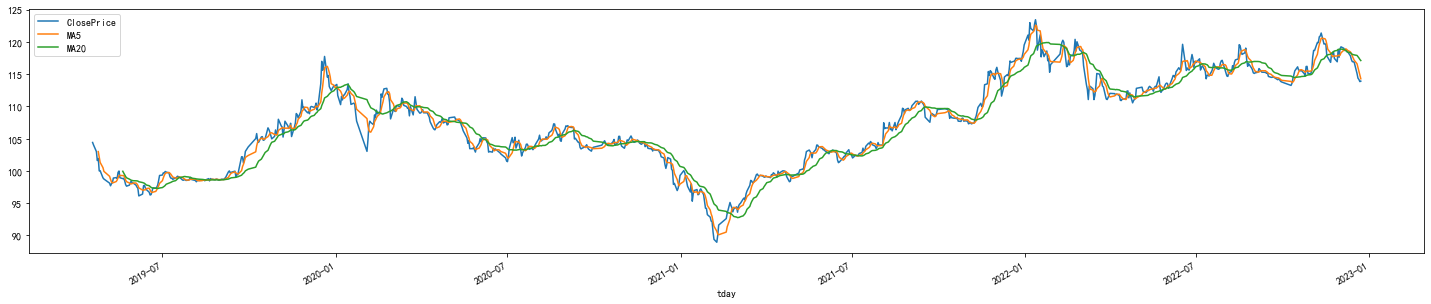

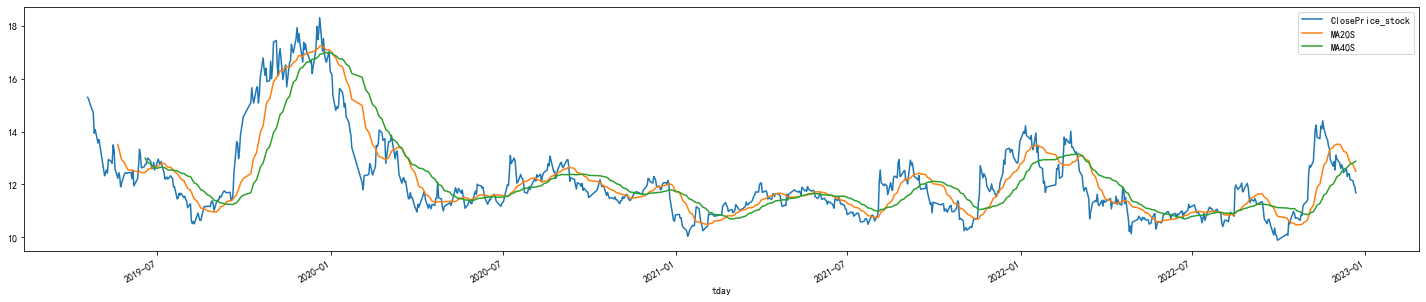

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
12      177291     308658 2022-12-21             0.812139    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
12        NaN            NaN      -0.001805  113037.SH     紫银转债     NaN   

    Norm_ret  
12 -0.018112  


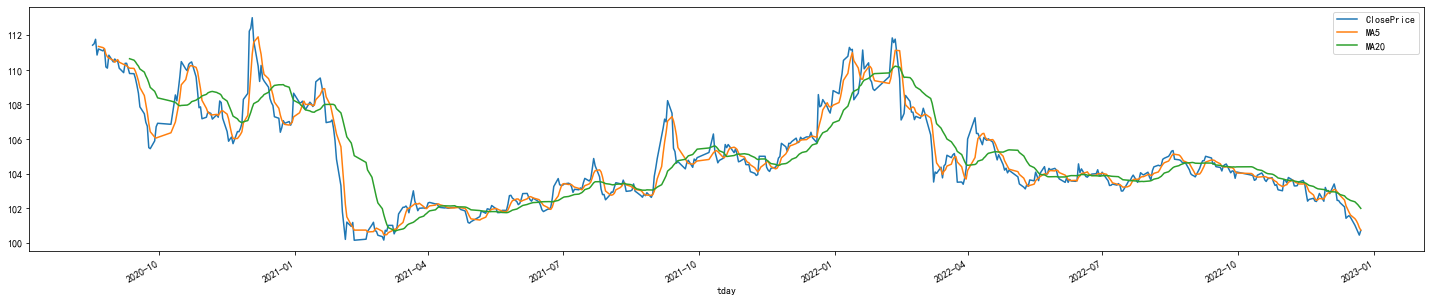

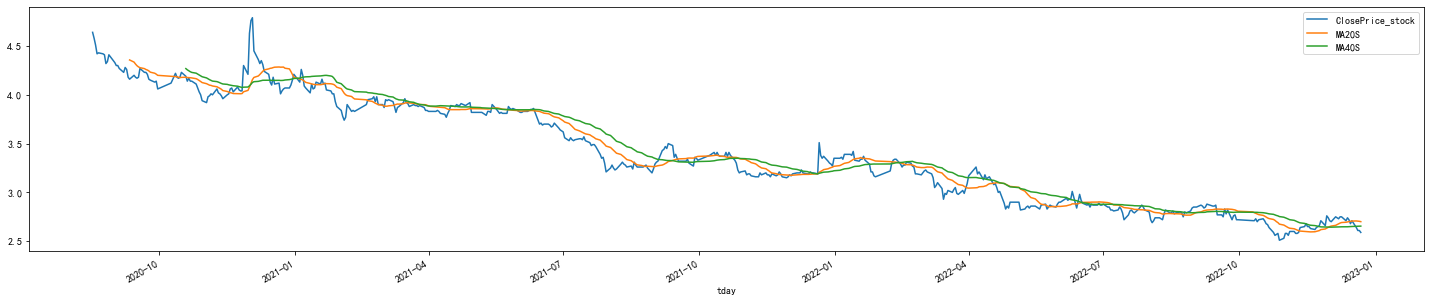

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
13      210665     346462 2022-12-21             0.130058    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
13        NaN            NaN       -0.02562  113621.SH     彤程转债     NaN   

    Norm_ret  
13 -2.079491  


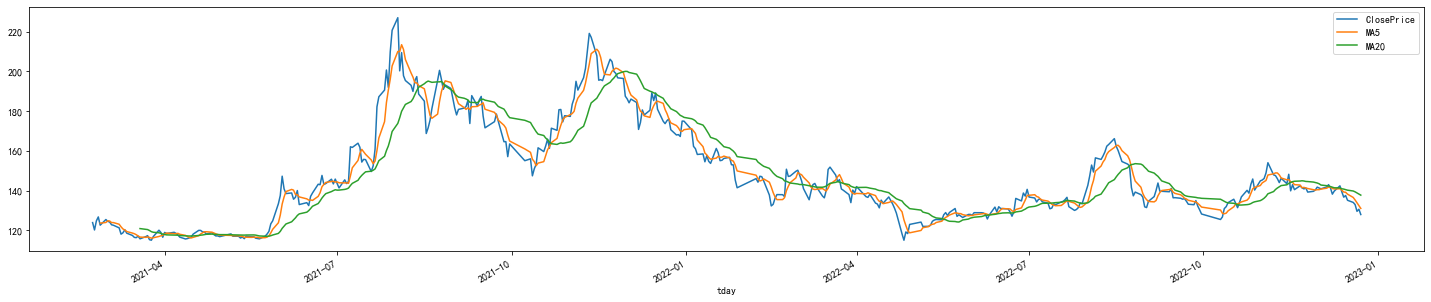

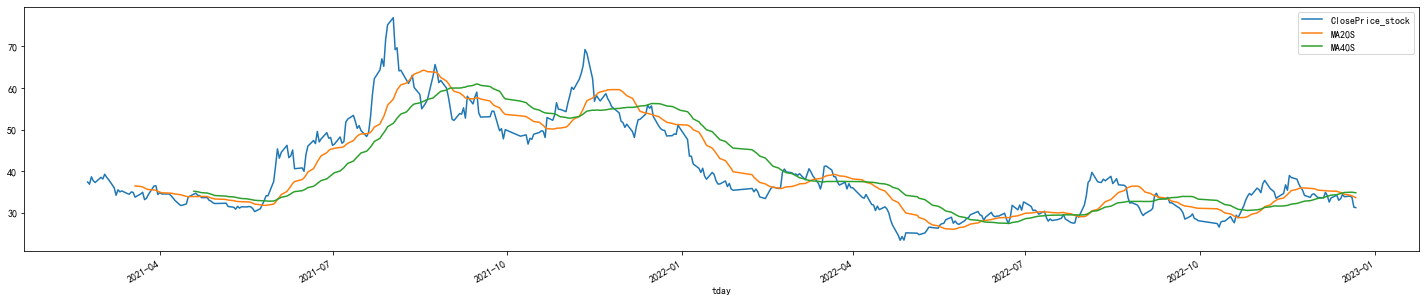

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
14      104598     223968 2022-12-21              0.99422    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
14        NaN            NaN      -0.025809  113025.SH     明泰转债     NaN   

    Norm_ret  
14 -2.147017  


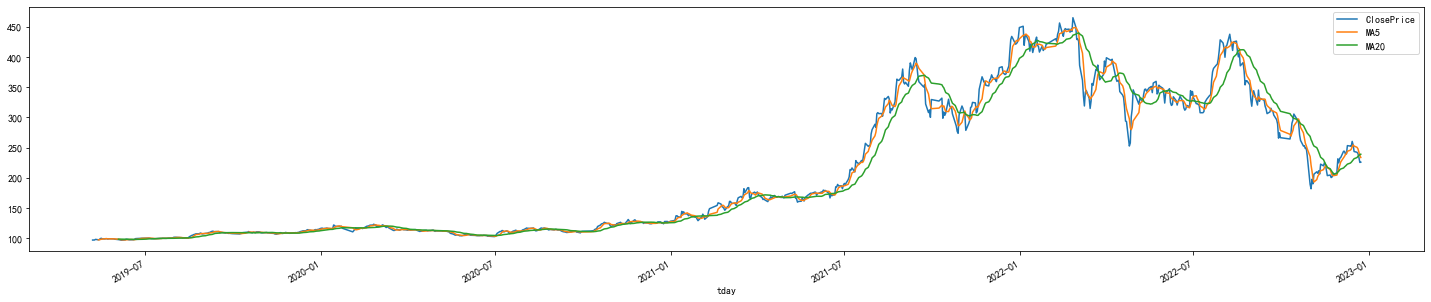

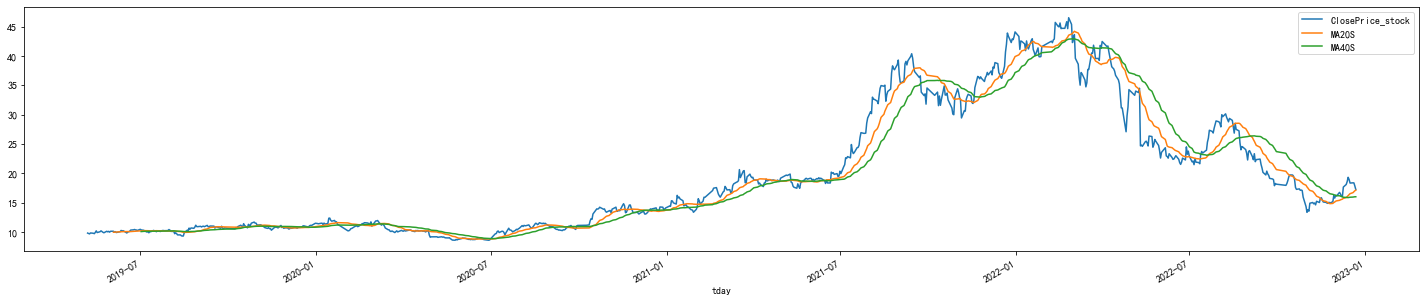

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
15      103821     223692 2022-12-21             0.034682    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
15        NaN            NaN      -0.026057  113534.SH     鼎胜转债     NaN   

    Norm_ret  
15 -2.226039  


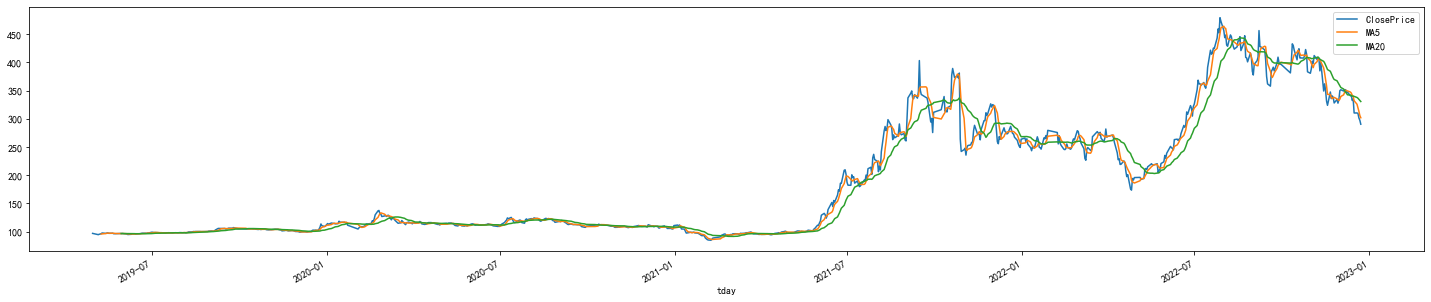

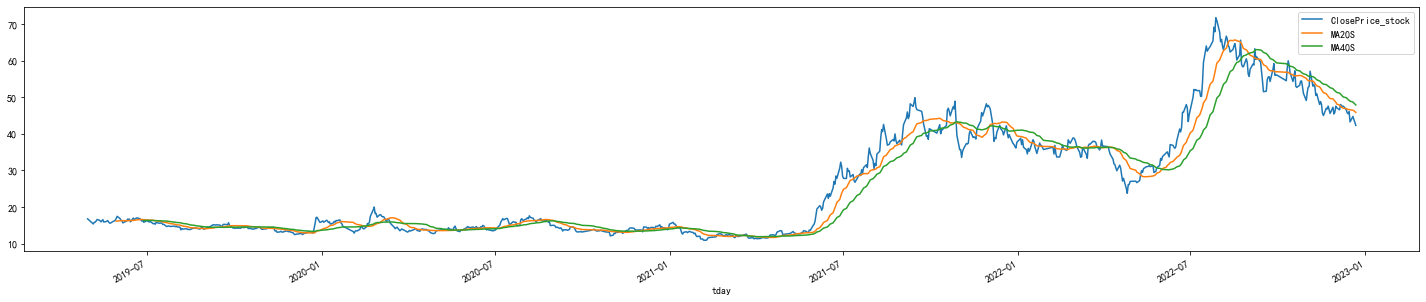

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
16      224511     382130 2022-12-21             0.563584    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
16        NaN            NaN      -0.026802  113626.SH     伯特转债     NaN   

    Norm_ret  
16 -2.322032  


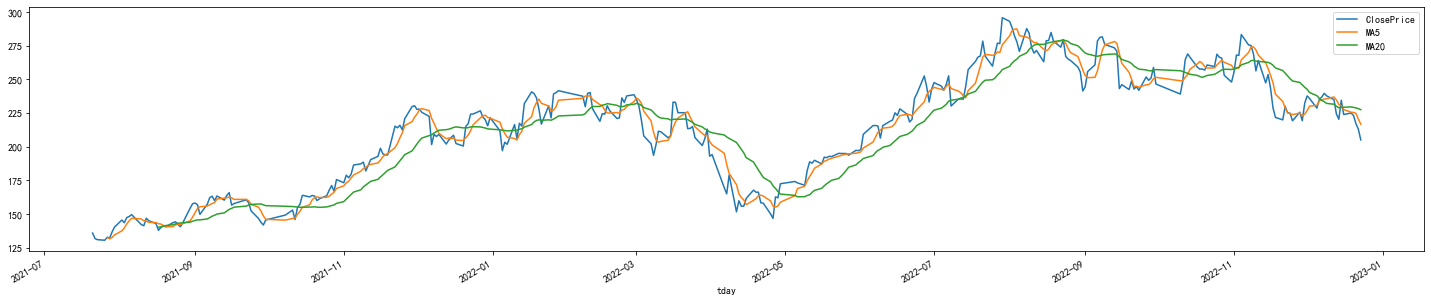

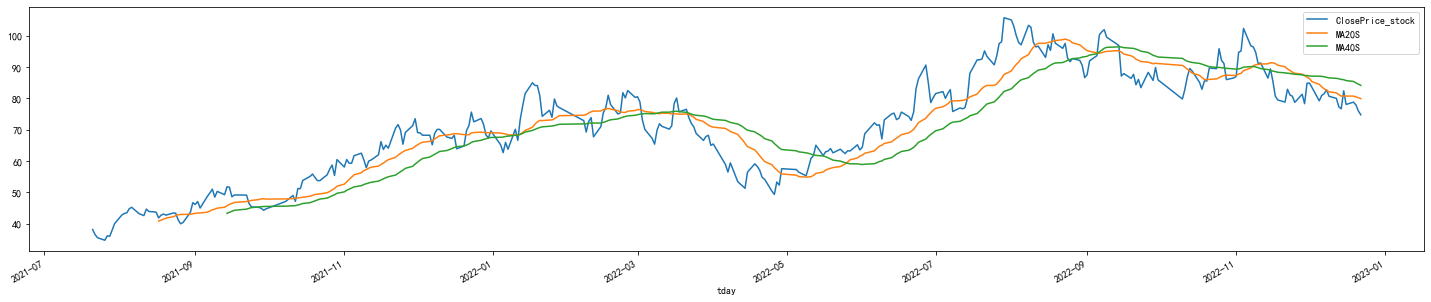

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
17      189301     320195 2022-12-21             0.057803    NaN  True   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
17        4.0           17.0      -0.027309  123067.SZ     斯莱转债 -0.027309   

    Norm_ret  
17 -2.445856  


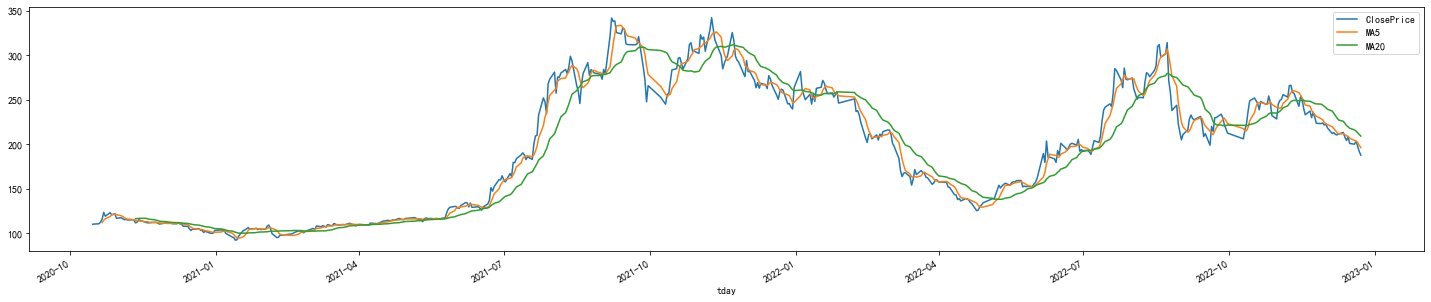

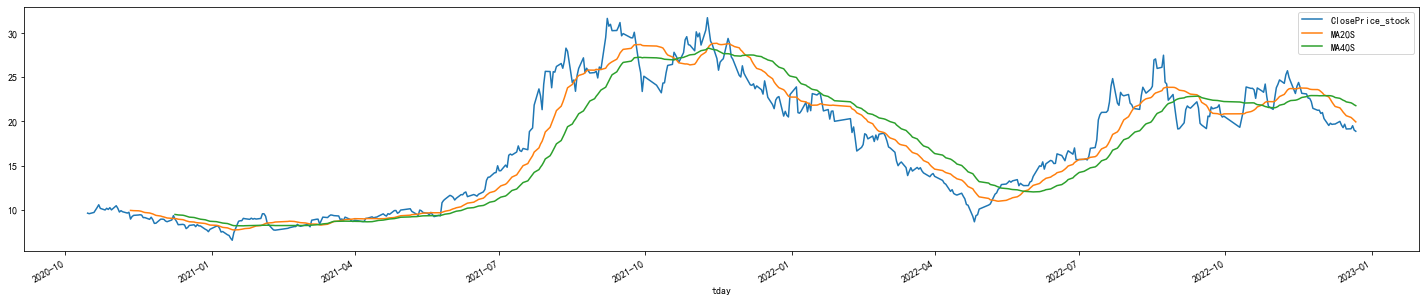

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma   hld  \
18      109862     233277 2022-12-21             0.040462    NaN  True   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr   ret_hld  \
18        2.0            3.0      -0.041044  113537.SH     文灿转债 -0.041044   

    Norm_ret  
18 -2.624779  


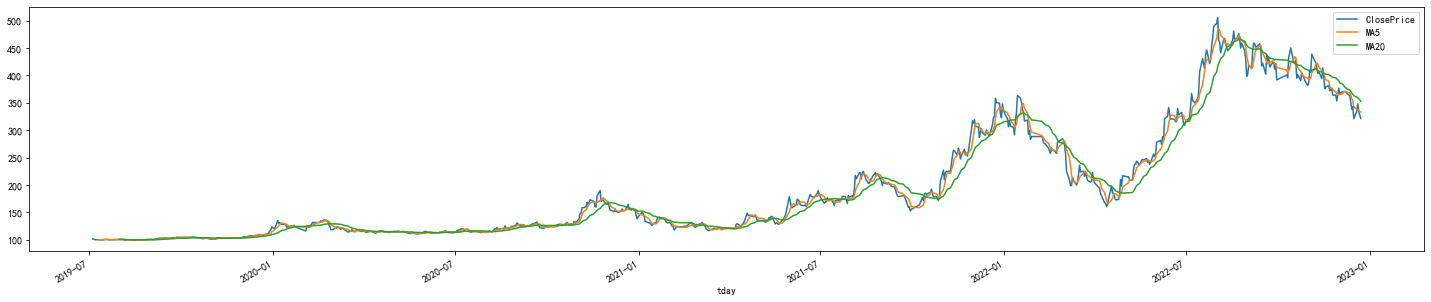

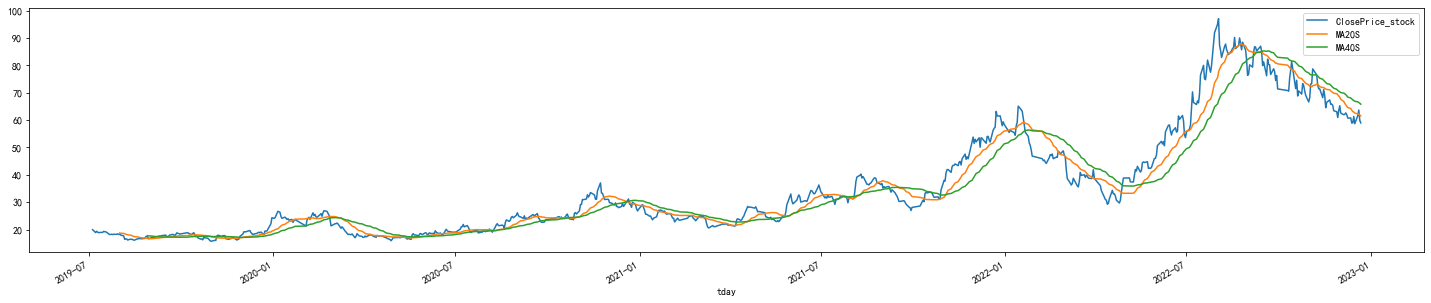

    Unnamed: 0  InnerCode       tday  ma5/ma20_daily_rank sig_ma  hld  \
19      180867     309938 2022-12-21             0.979769    NaN  NaN   

    hld_count  Cons_hld_days  Close_ret_adj  wind_code SecuAbbr ret_hld  \
19        NaN            NaN      -0.051432  113597.SH     佳力转债     NaN   

    Norm_ret  
19 -2.979184  


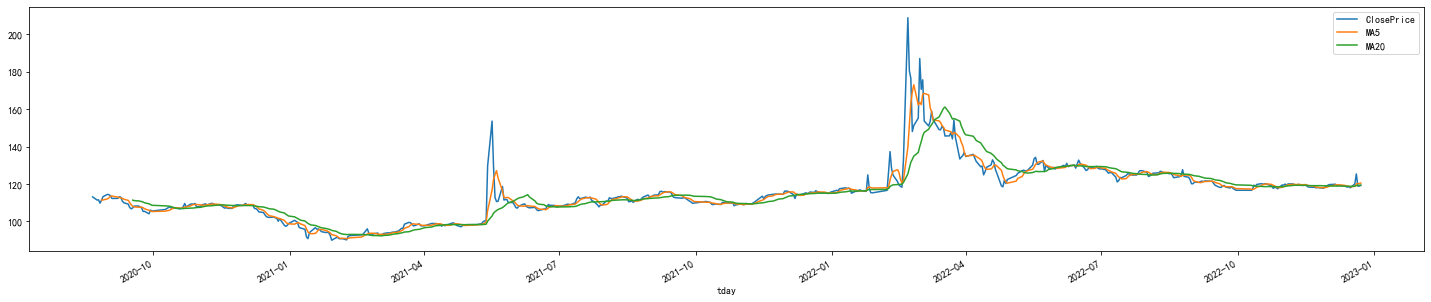

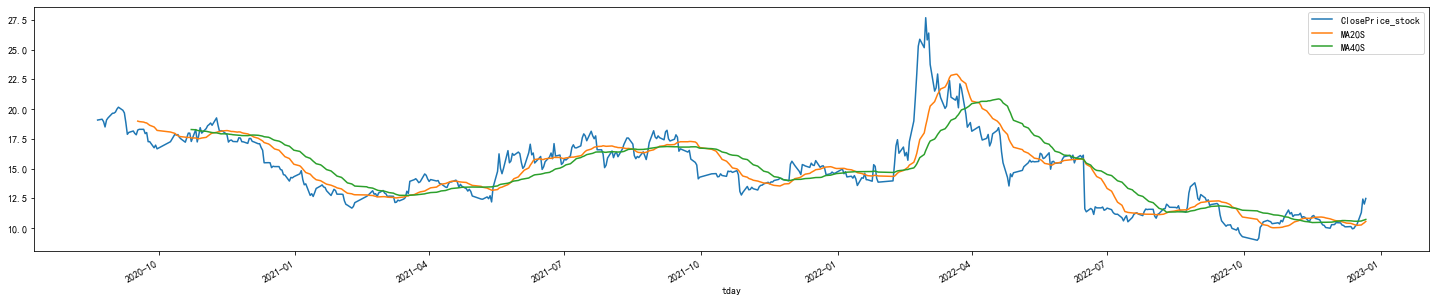

In [280]:
for i in daily_ret_brief.InnerCode:
    print(daily_ret_brief[daily_ret_brief.InnerCode==i])
    draw_bs(i)